# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.77'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne1.txt',
 '02 Ne2.txt',
 '03 Ne3.txt',
 '04 Ne4.txt',
 '05 Ne5.txt',
 '09 Ne6.txt',
 '13 Ne7.txt',
 '17 Ne8.txt',
 '19 Ne9.txt',
 '21 Ne10.txt',
 '23 Ne11.txt',
 '26 Ne12.txt',
 '29 Ne13.txt',
 '32 Ne14.txt',
 '35 Ne15.txt',
 '37 Ne16.txt',
 '41 Ne17.txt',
 '43 Ne18.txt',
 '45 Ne19.txt',
 '50 Ne20.txt',
 '54 Ne21.txt',
 '57 Ne22.txt',
 '59 Ne23.txt',
 '60 Ne24.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.72474        4380.0  1447.663174       37490.0  3680.700018   

     Peak2_prom  
0  36790.700018

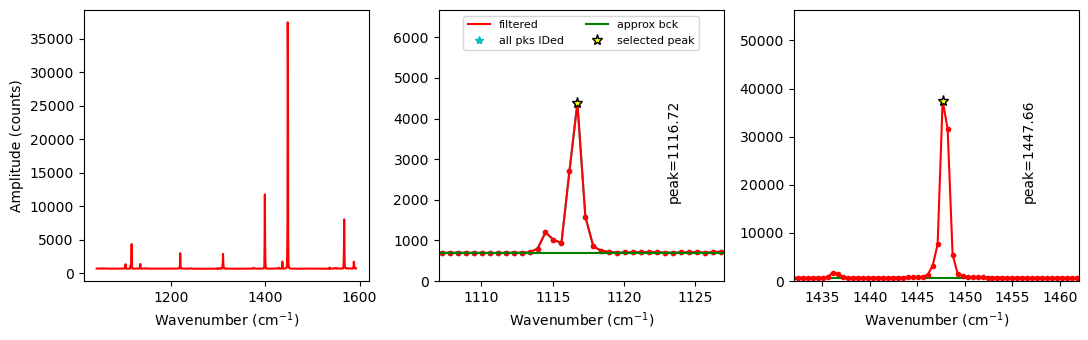

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne1.txt         0.000039    0.000039    1447.883402   46437.293416   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0   0.419338      None    0.00236        0.400014    1116.605374  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0       None   0.012551       0.292431  331.278027  0.997584     0.997539   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997629    109.968088     11.276938        121.245027  

[1 rows x 22 columns]

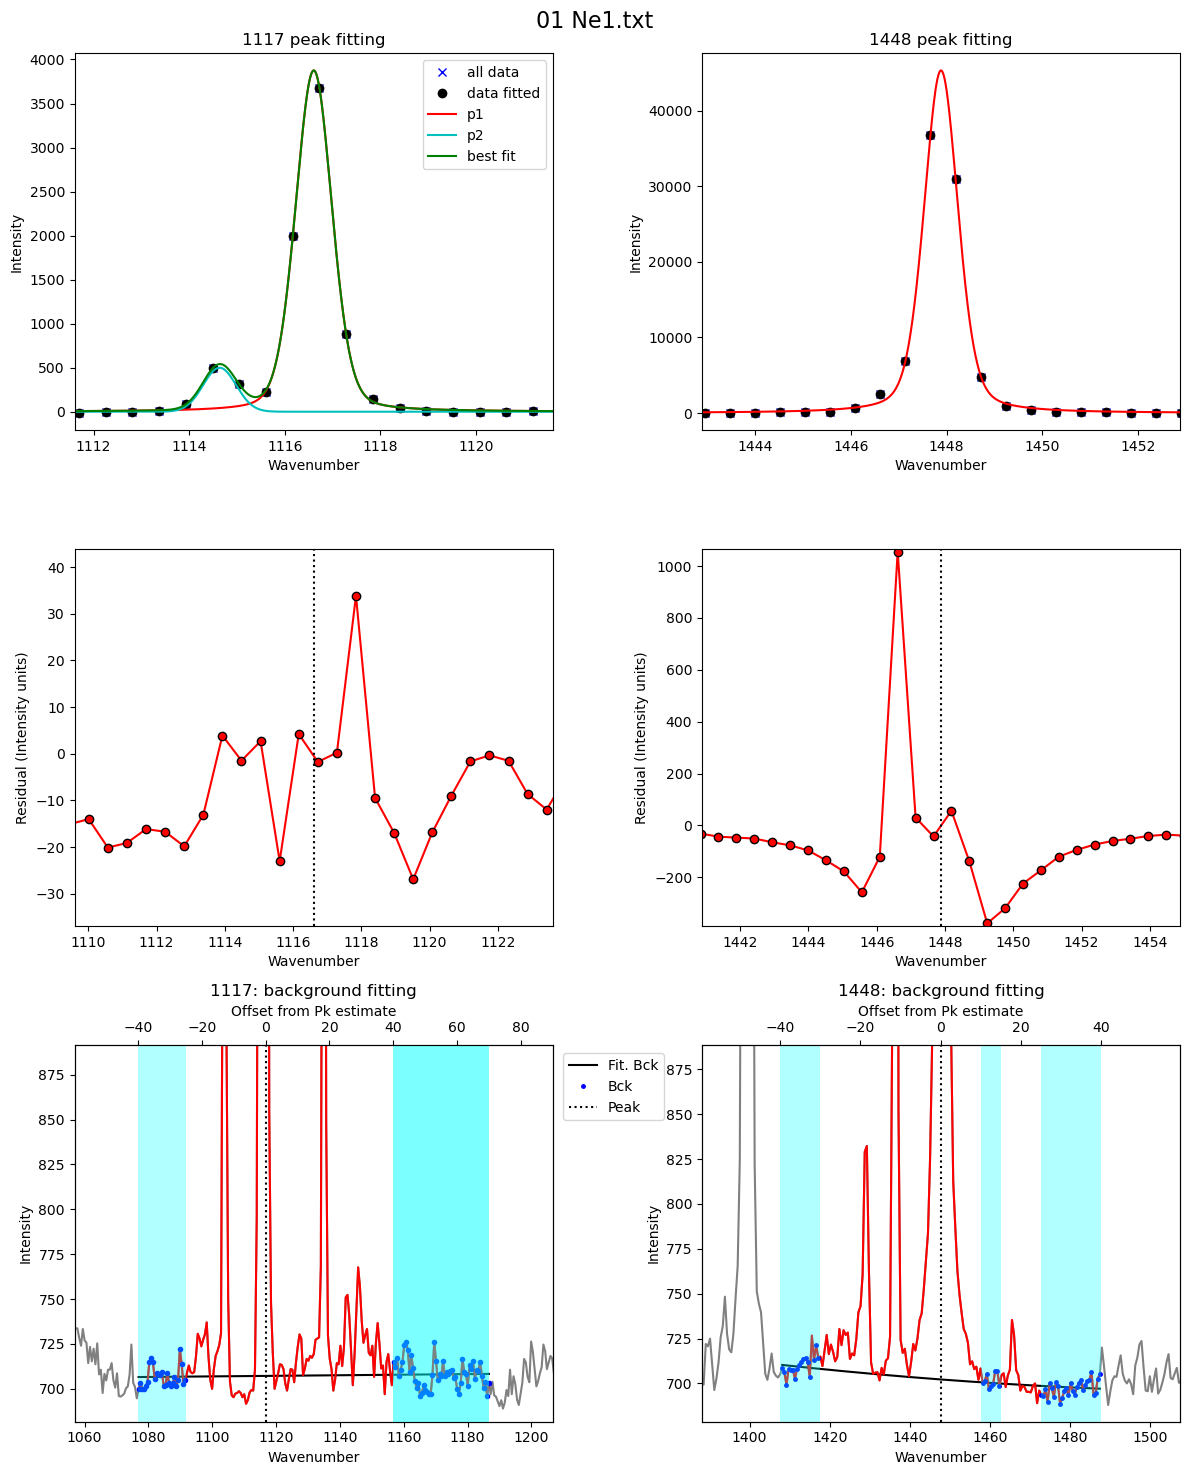

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/24 [00:00<?, ?it/s]

c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here


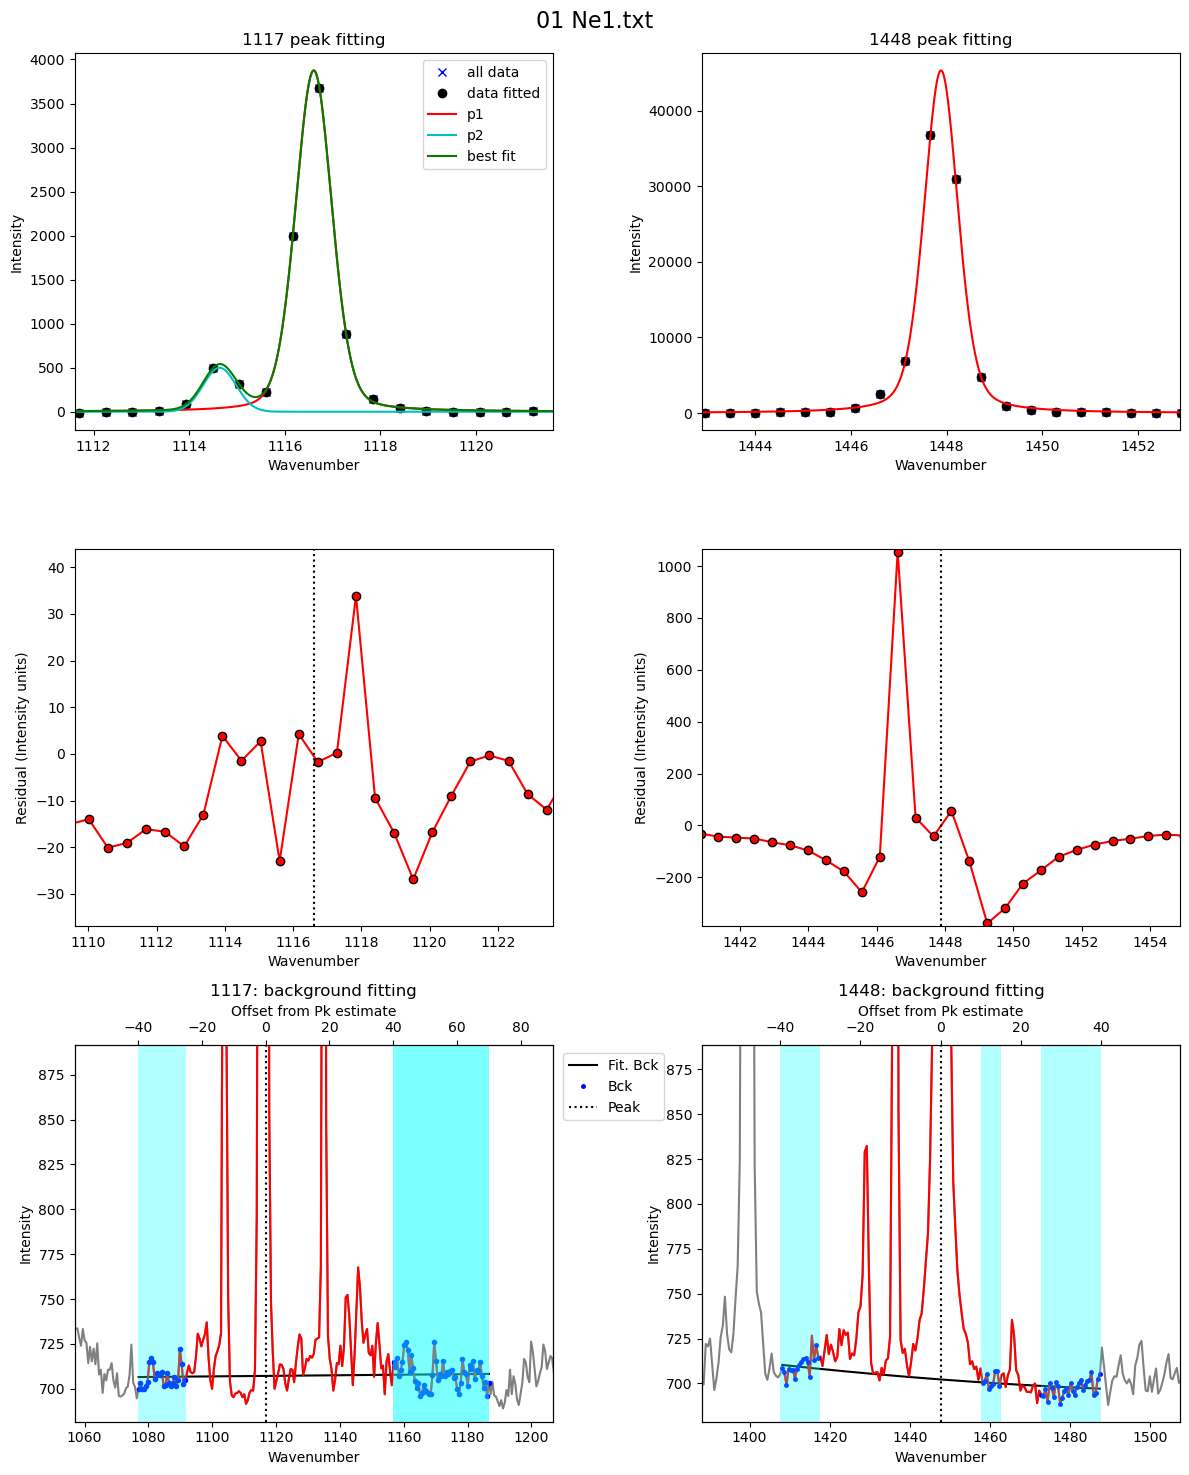

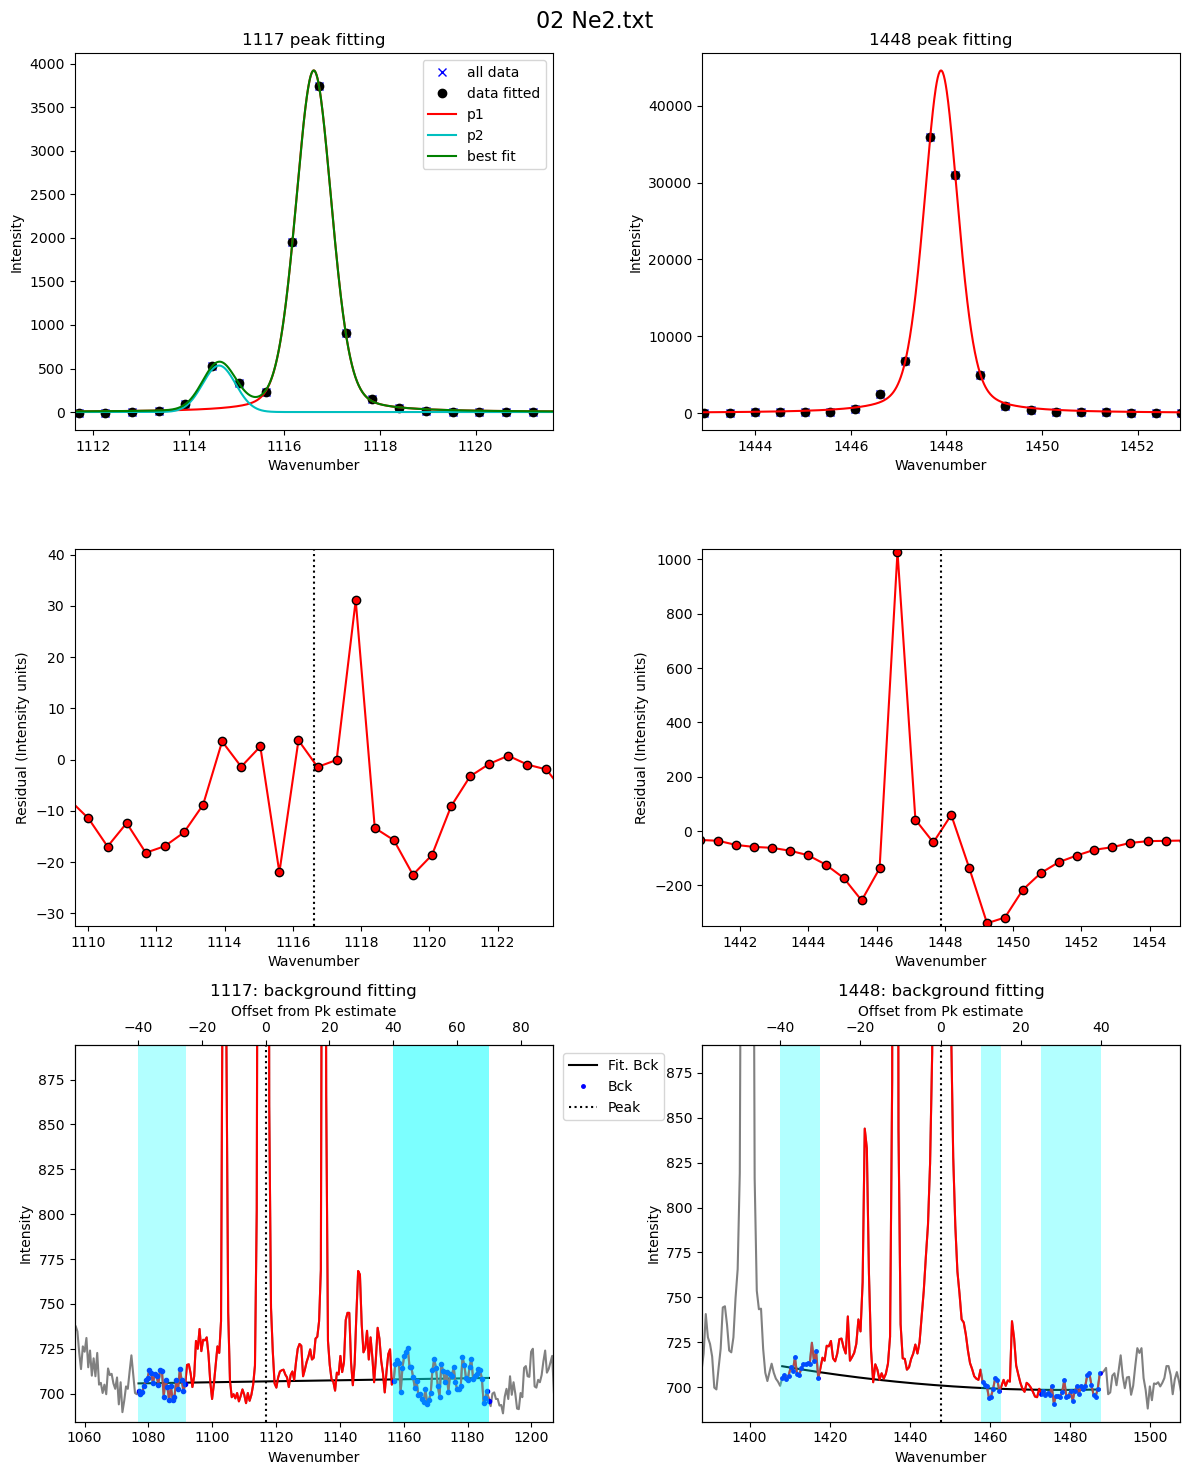

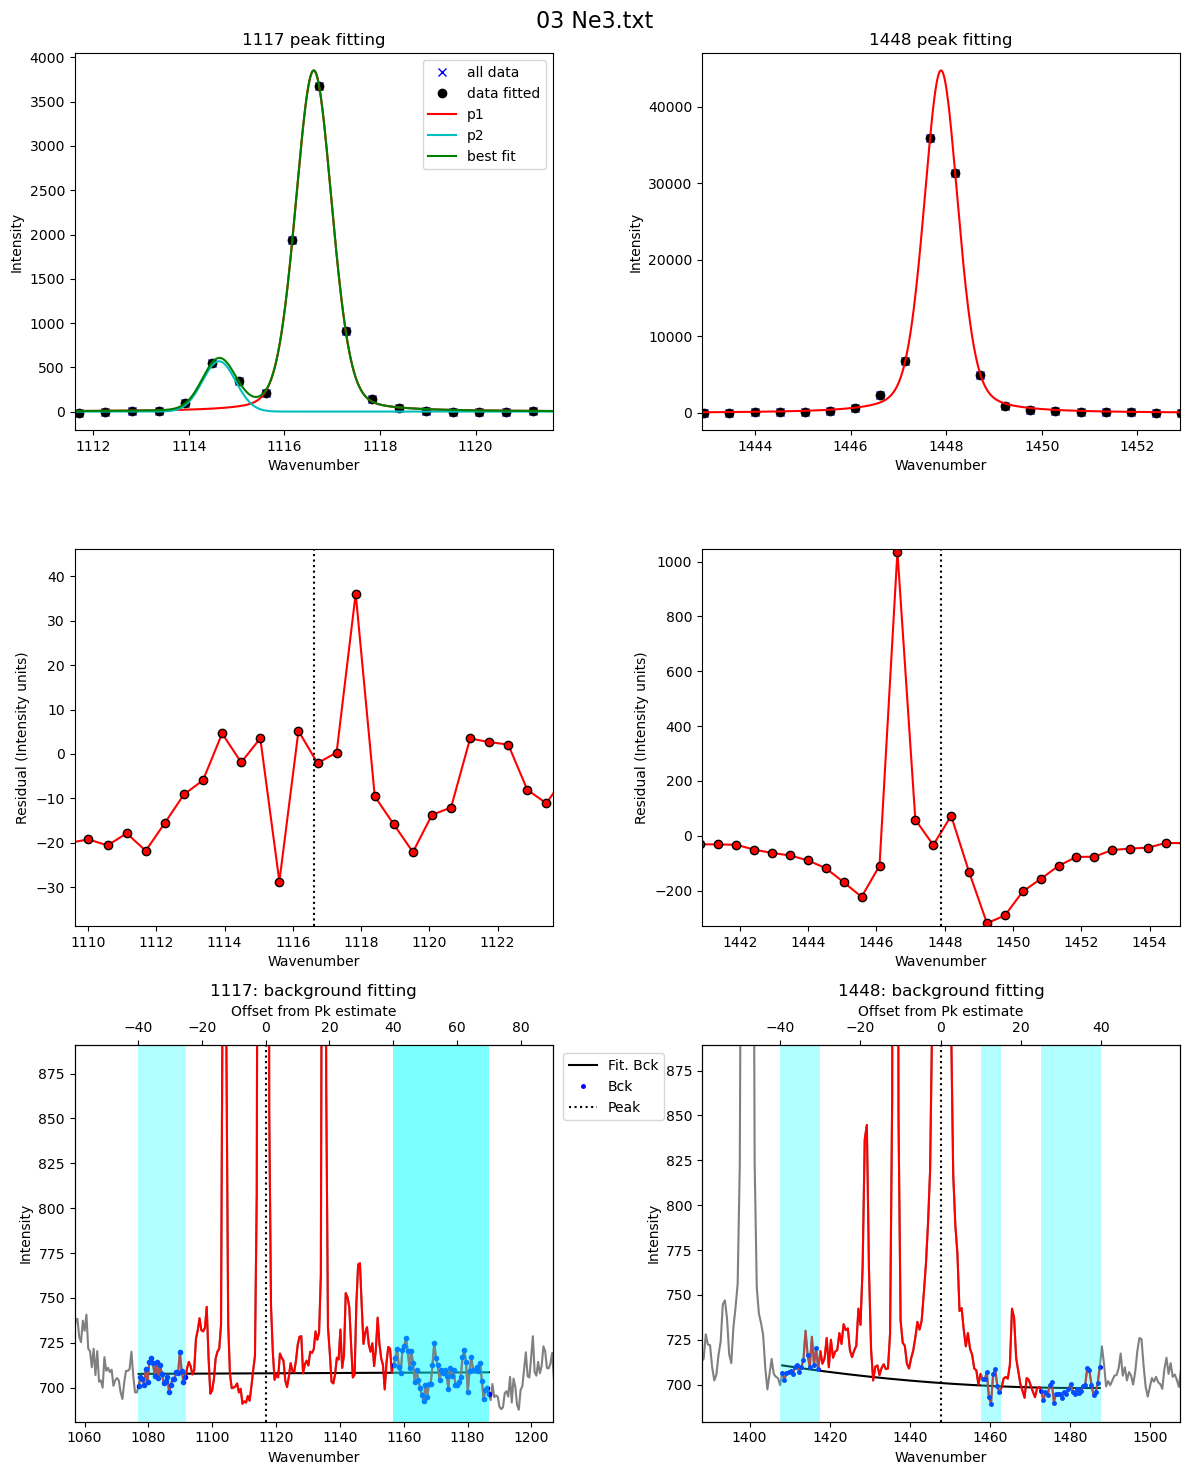

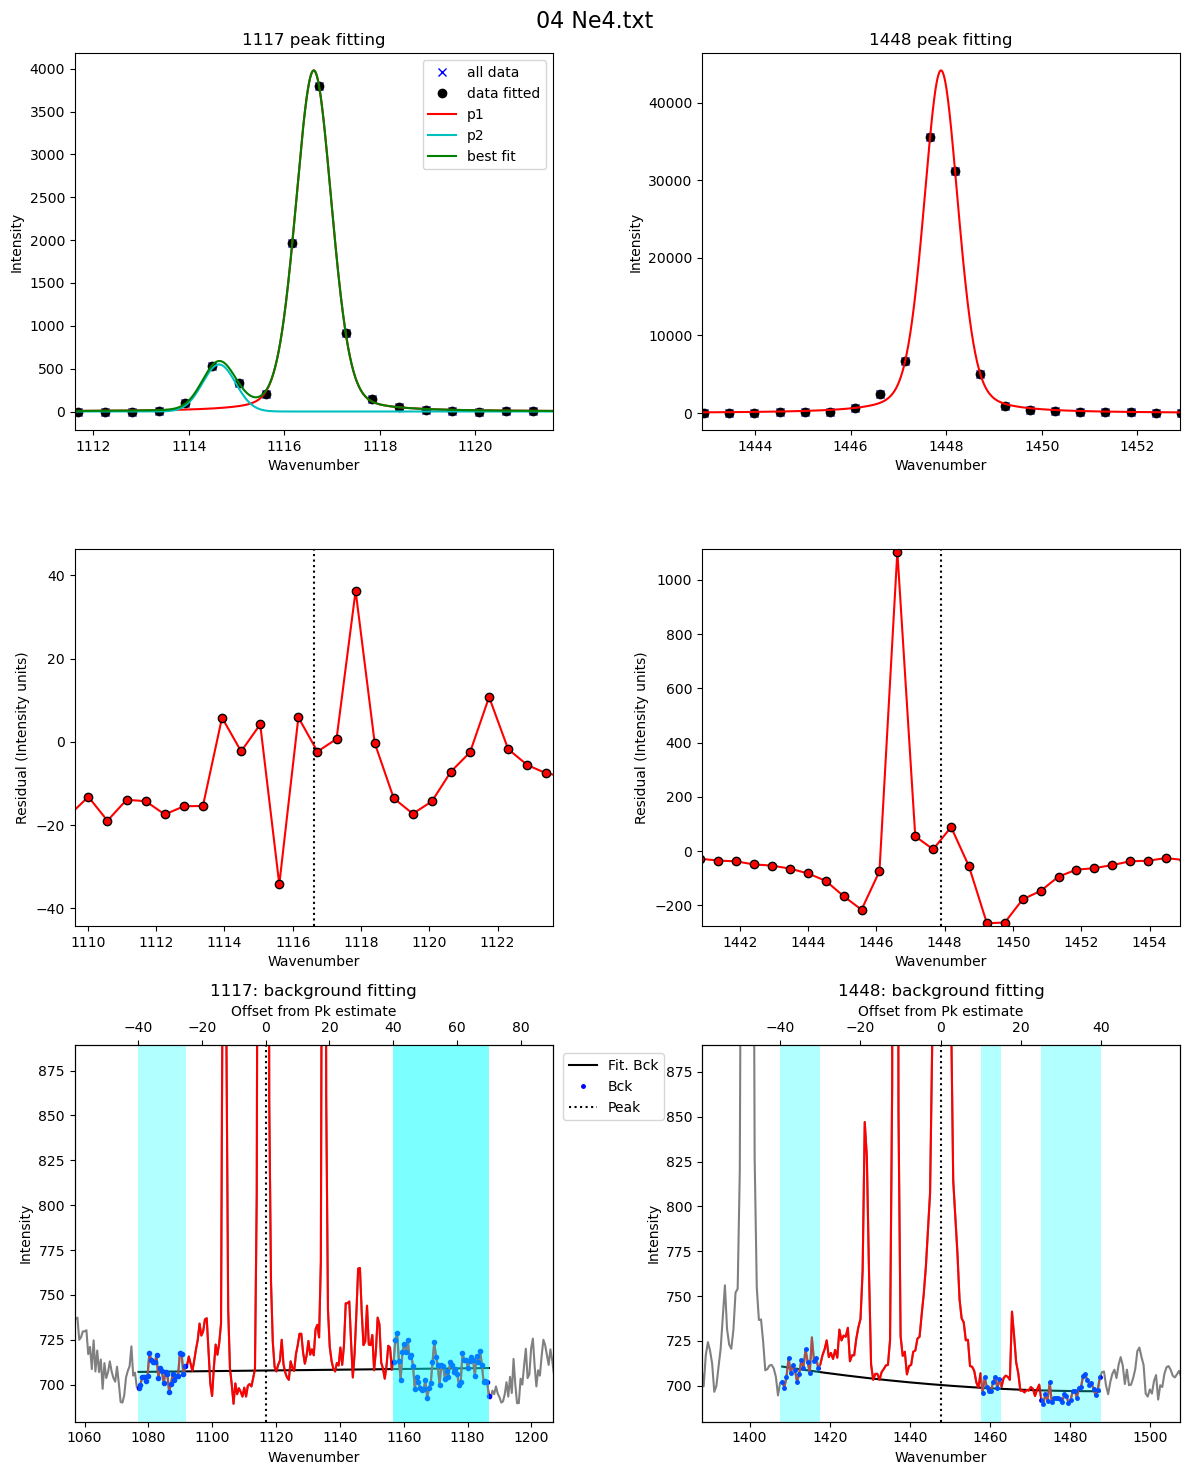

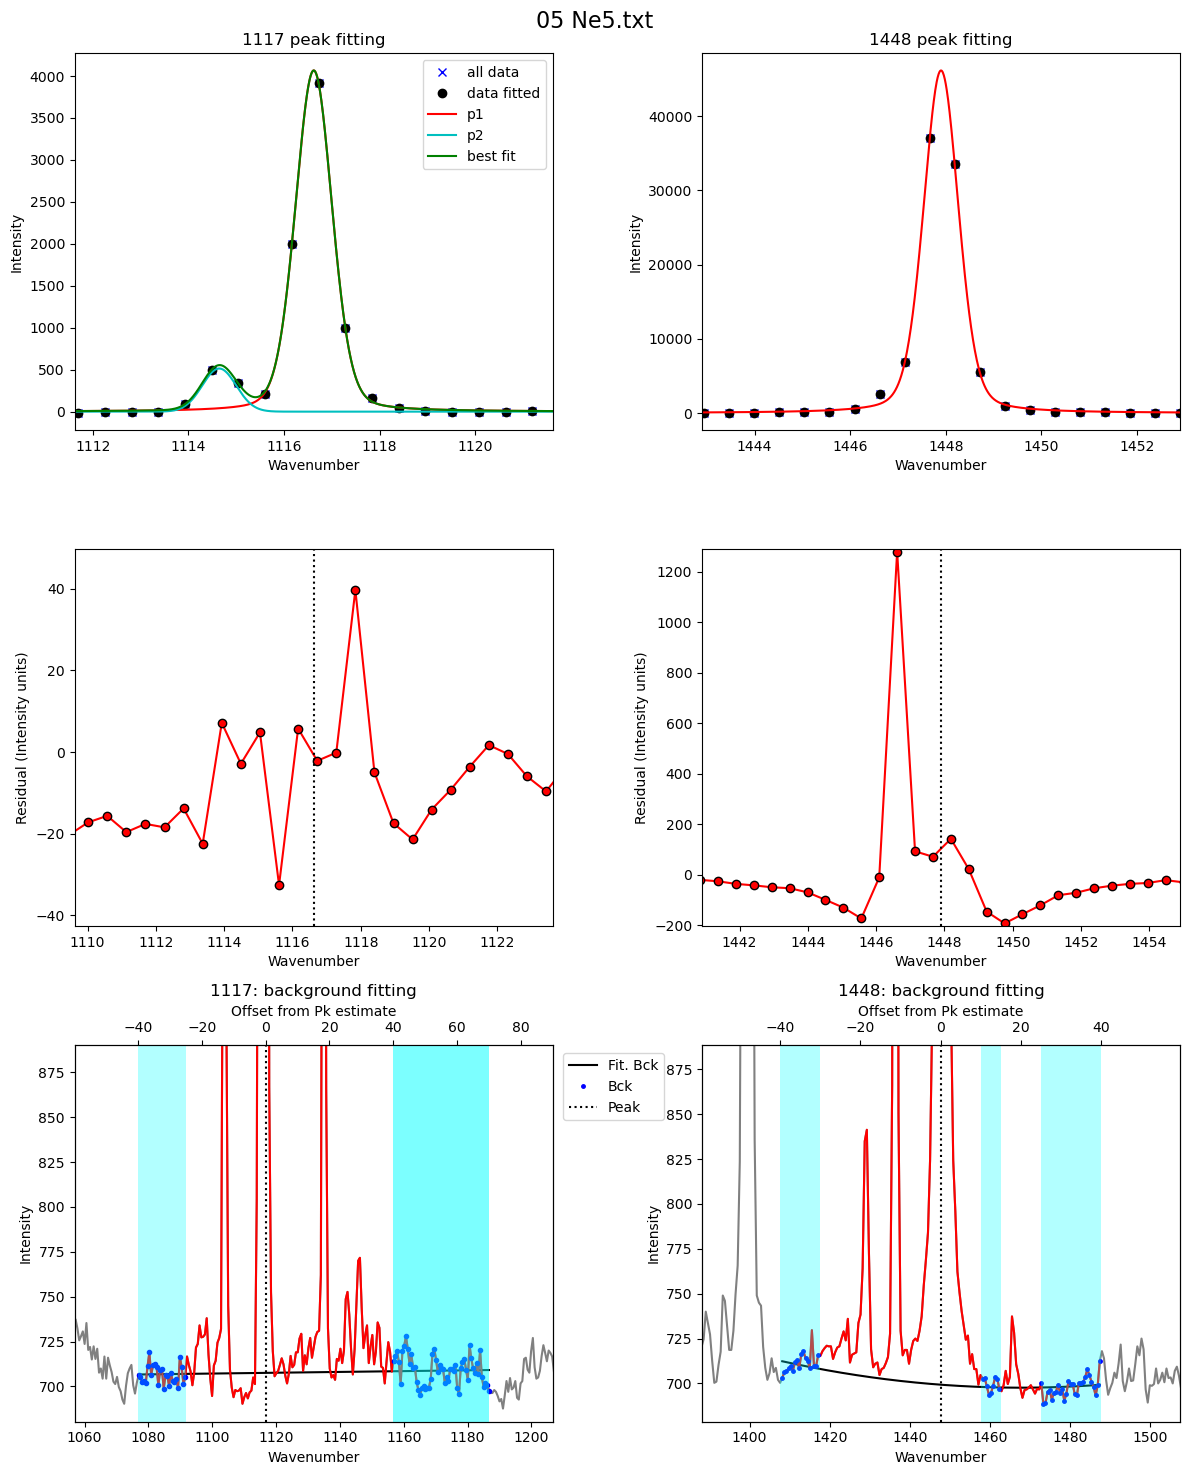

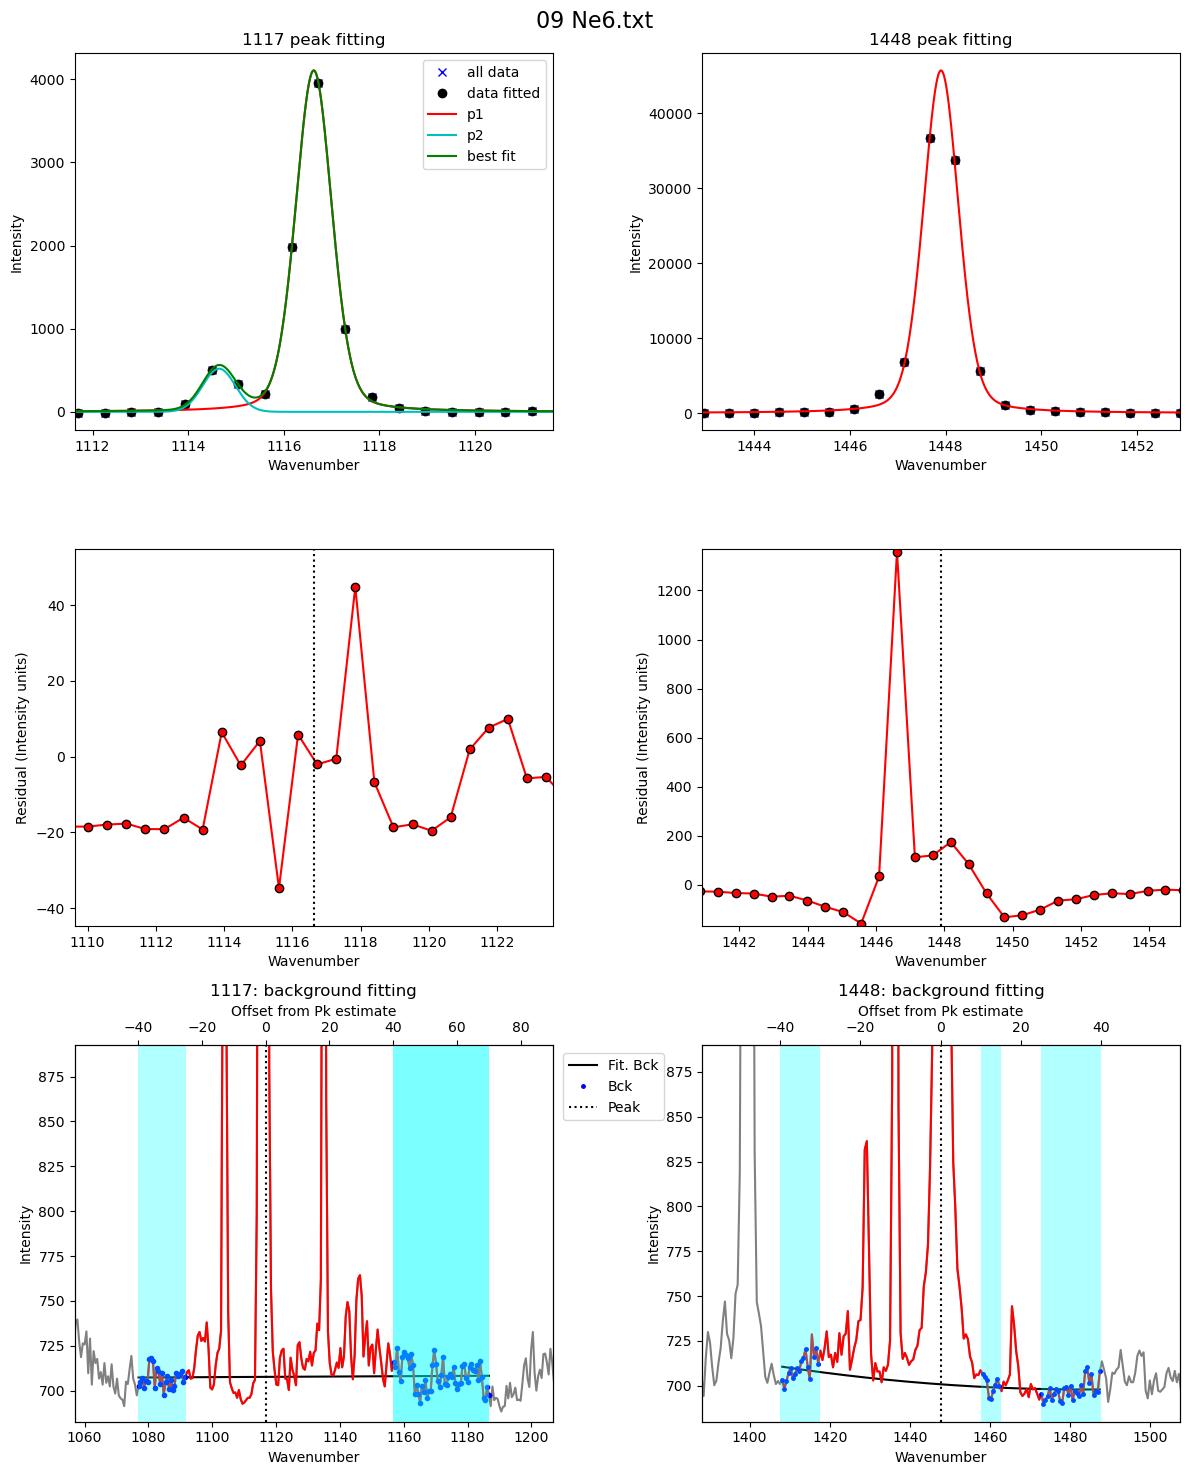

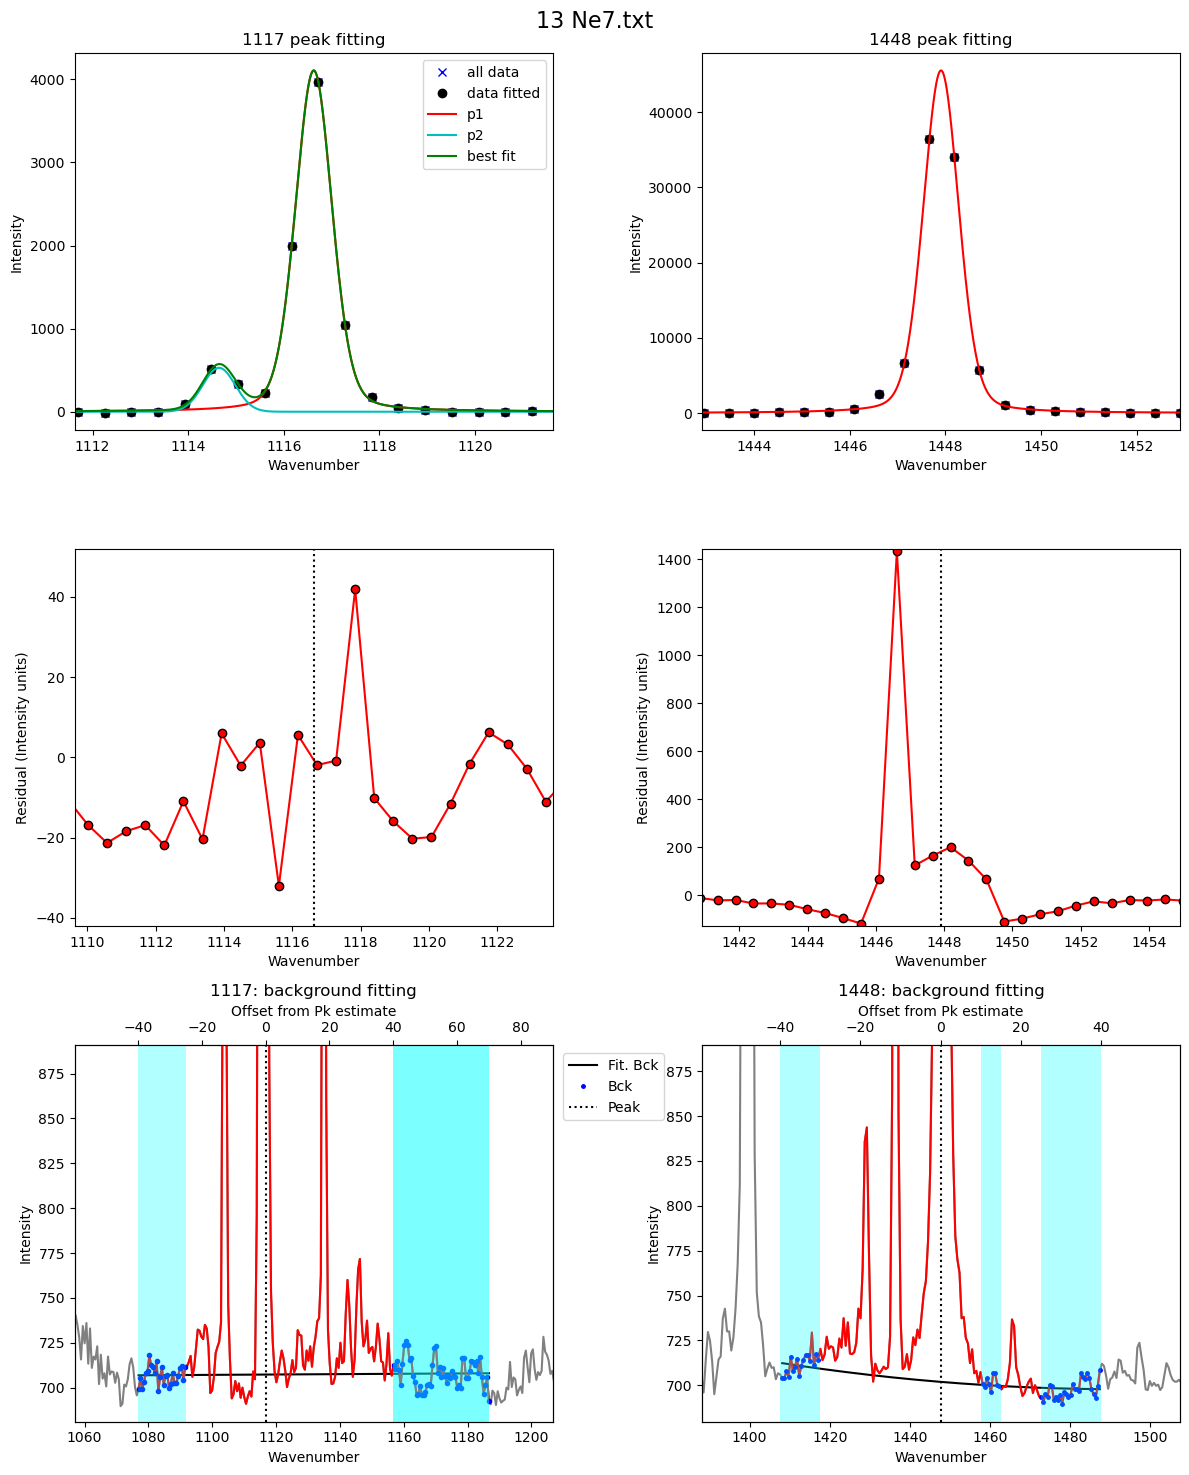

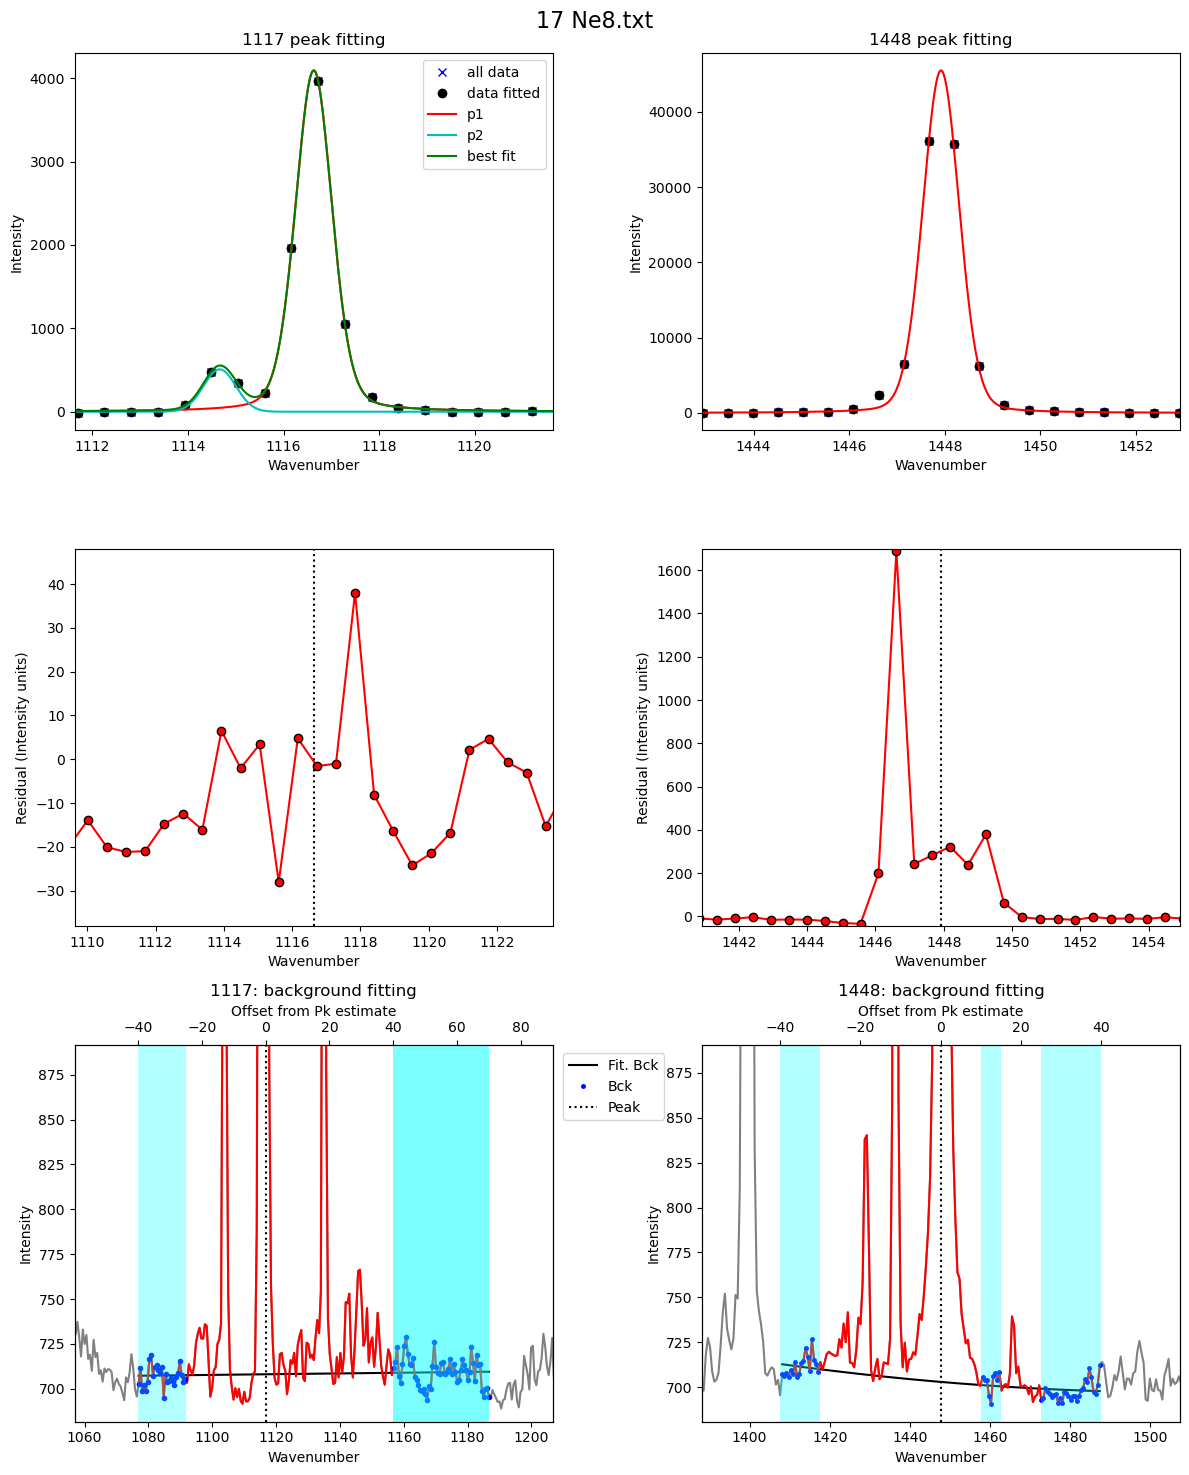

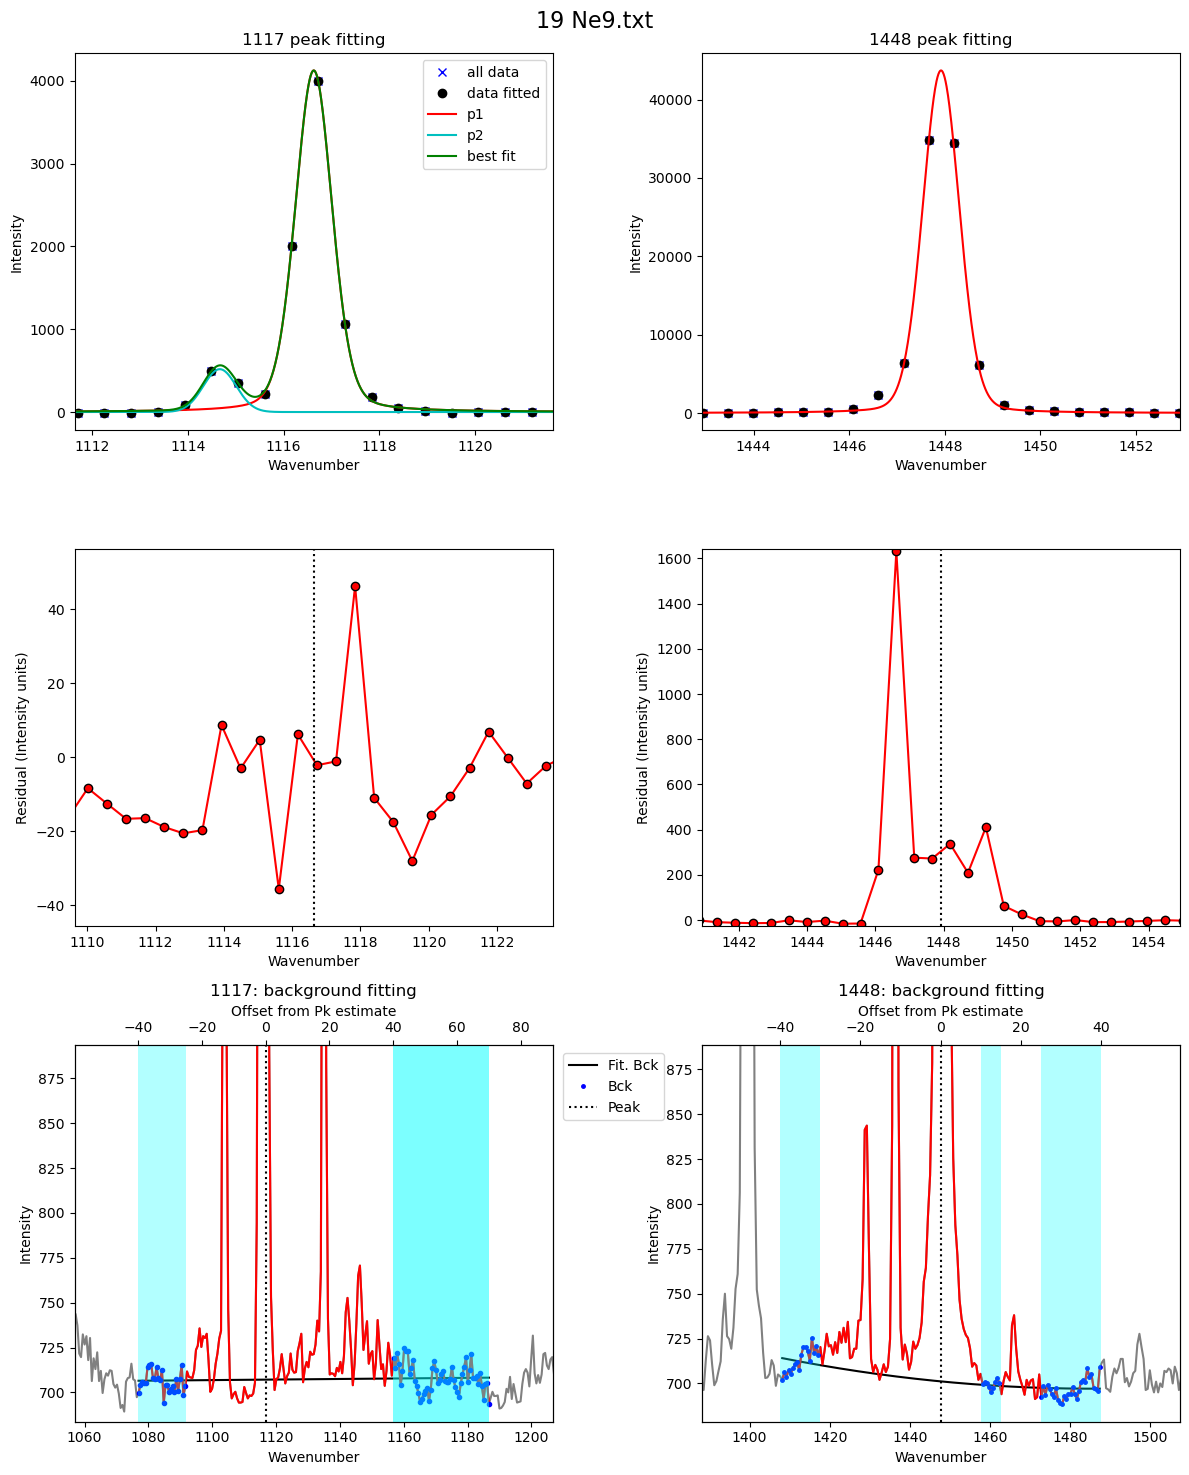

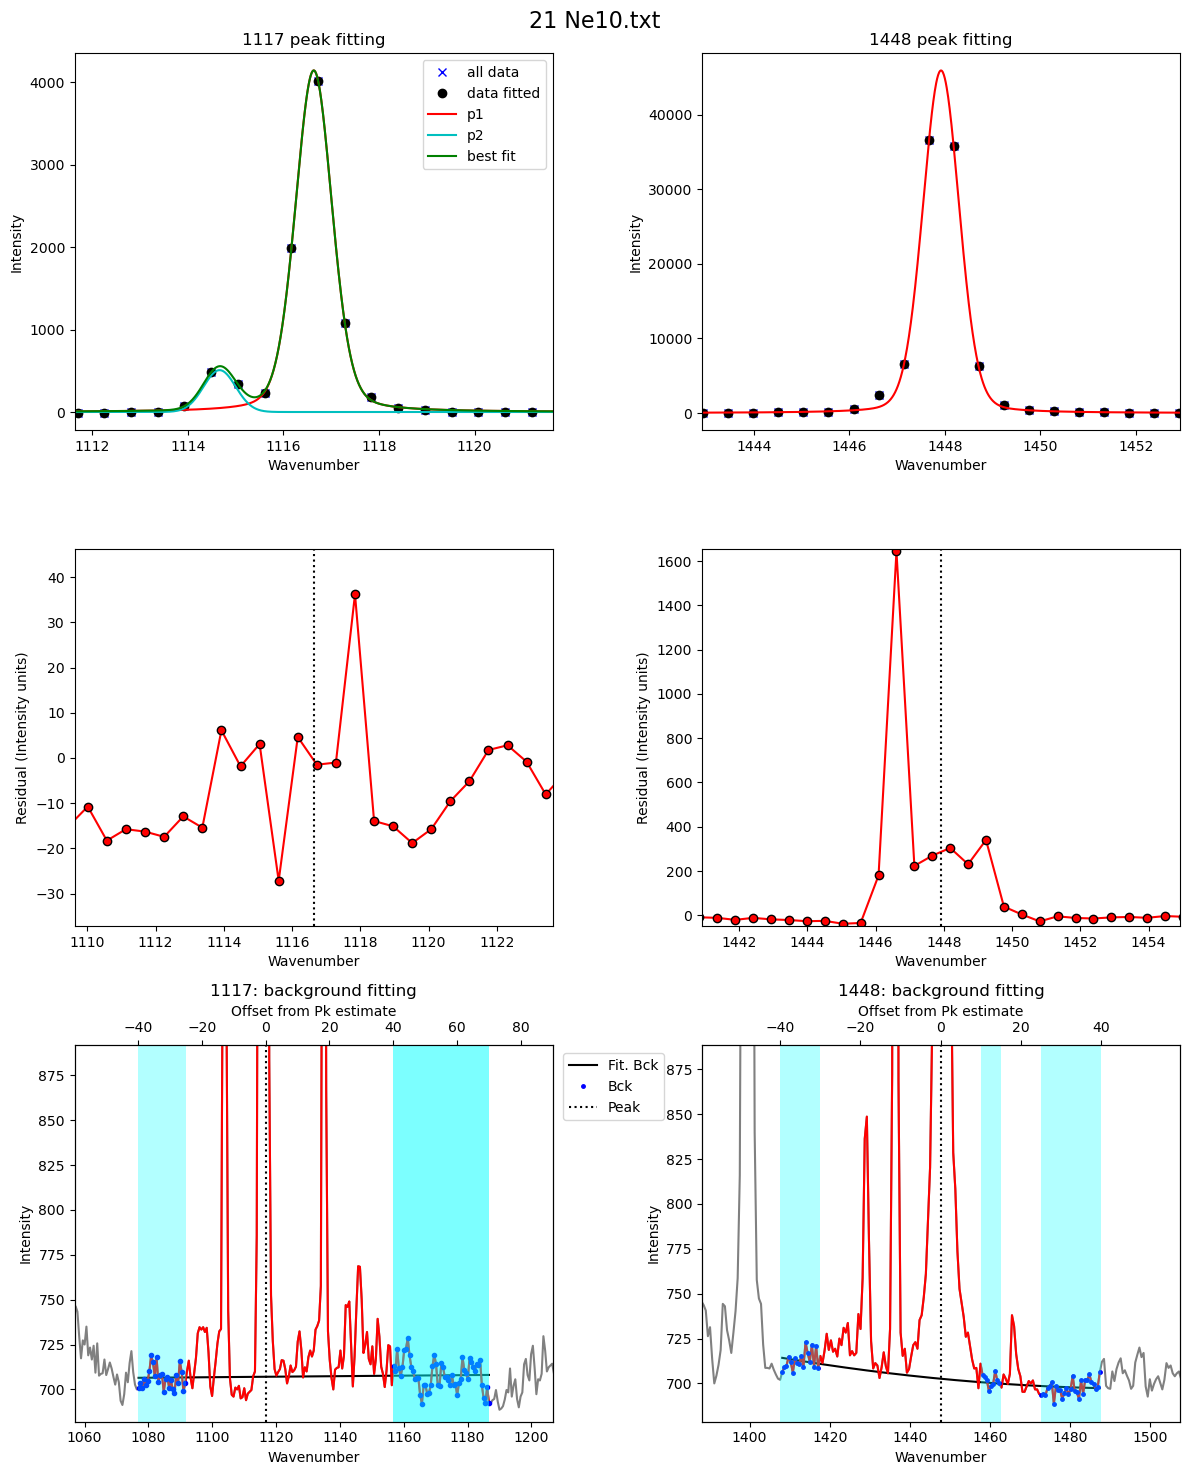

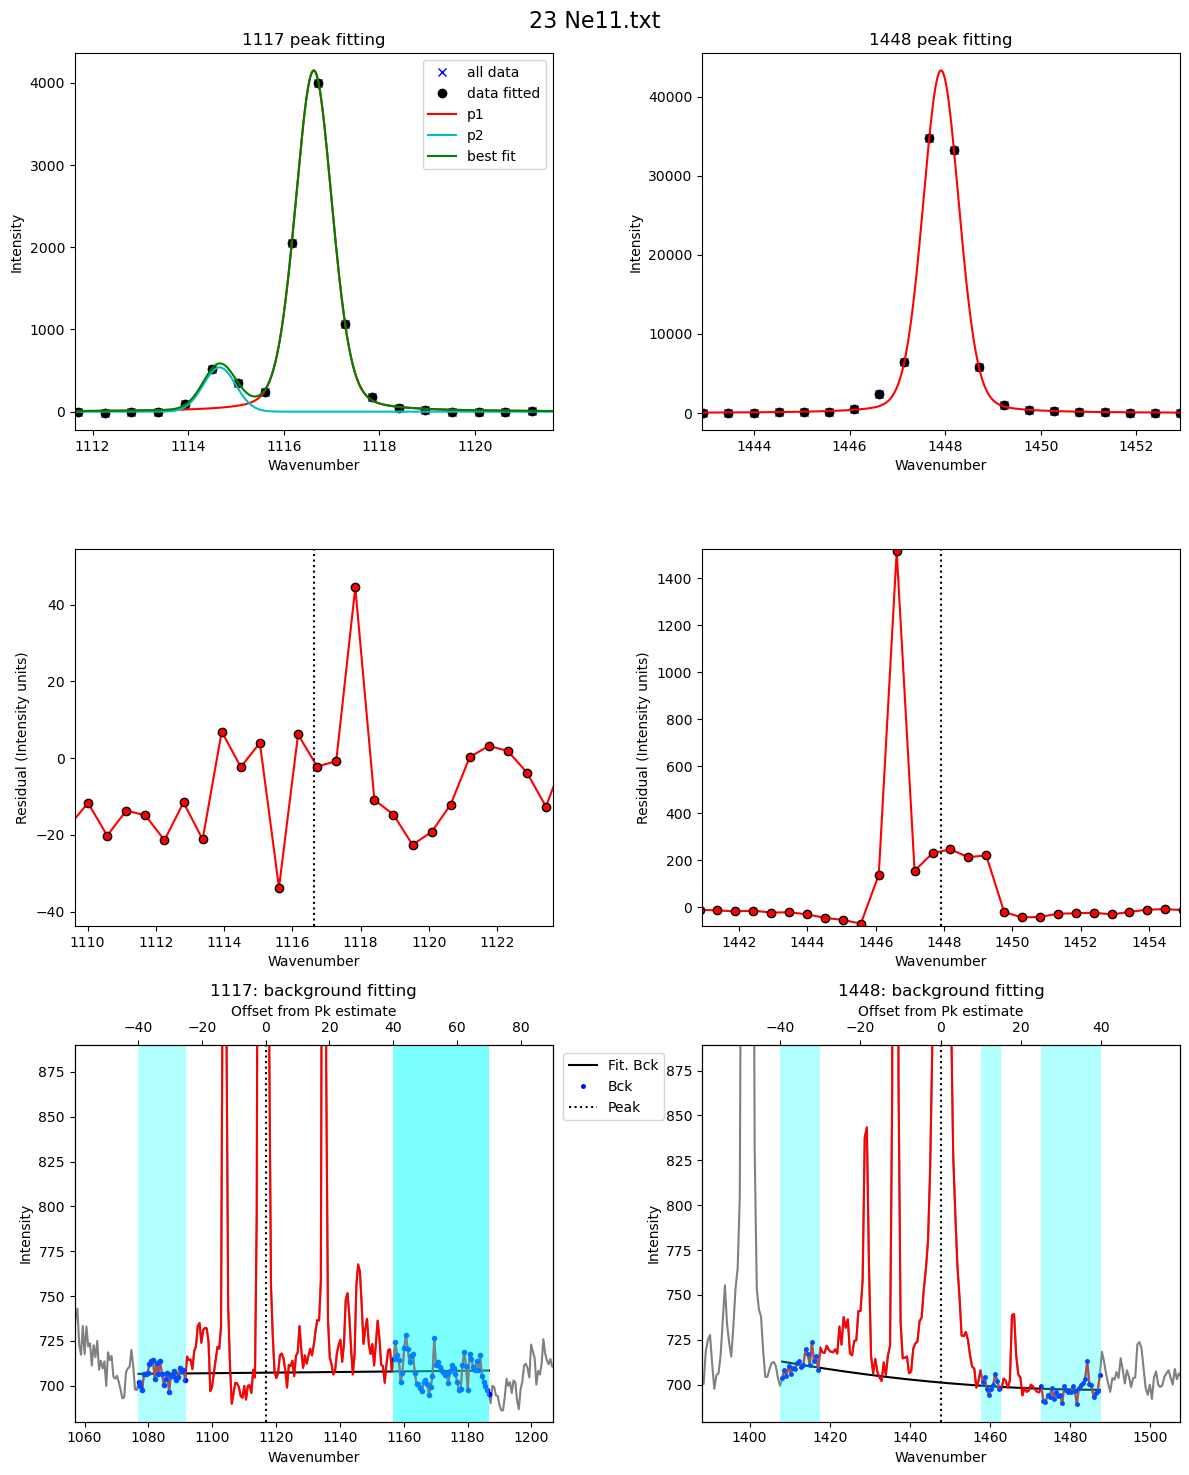

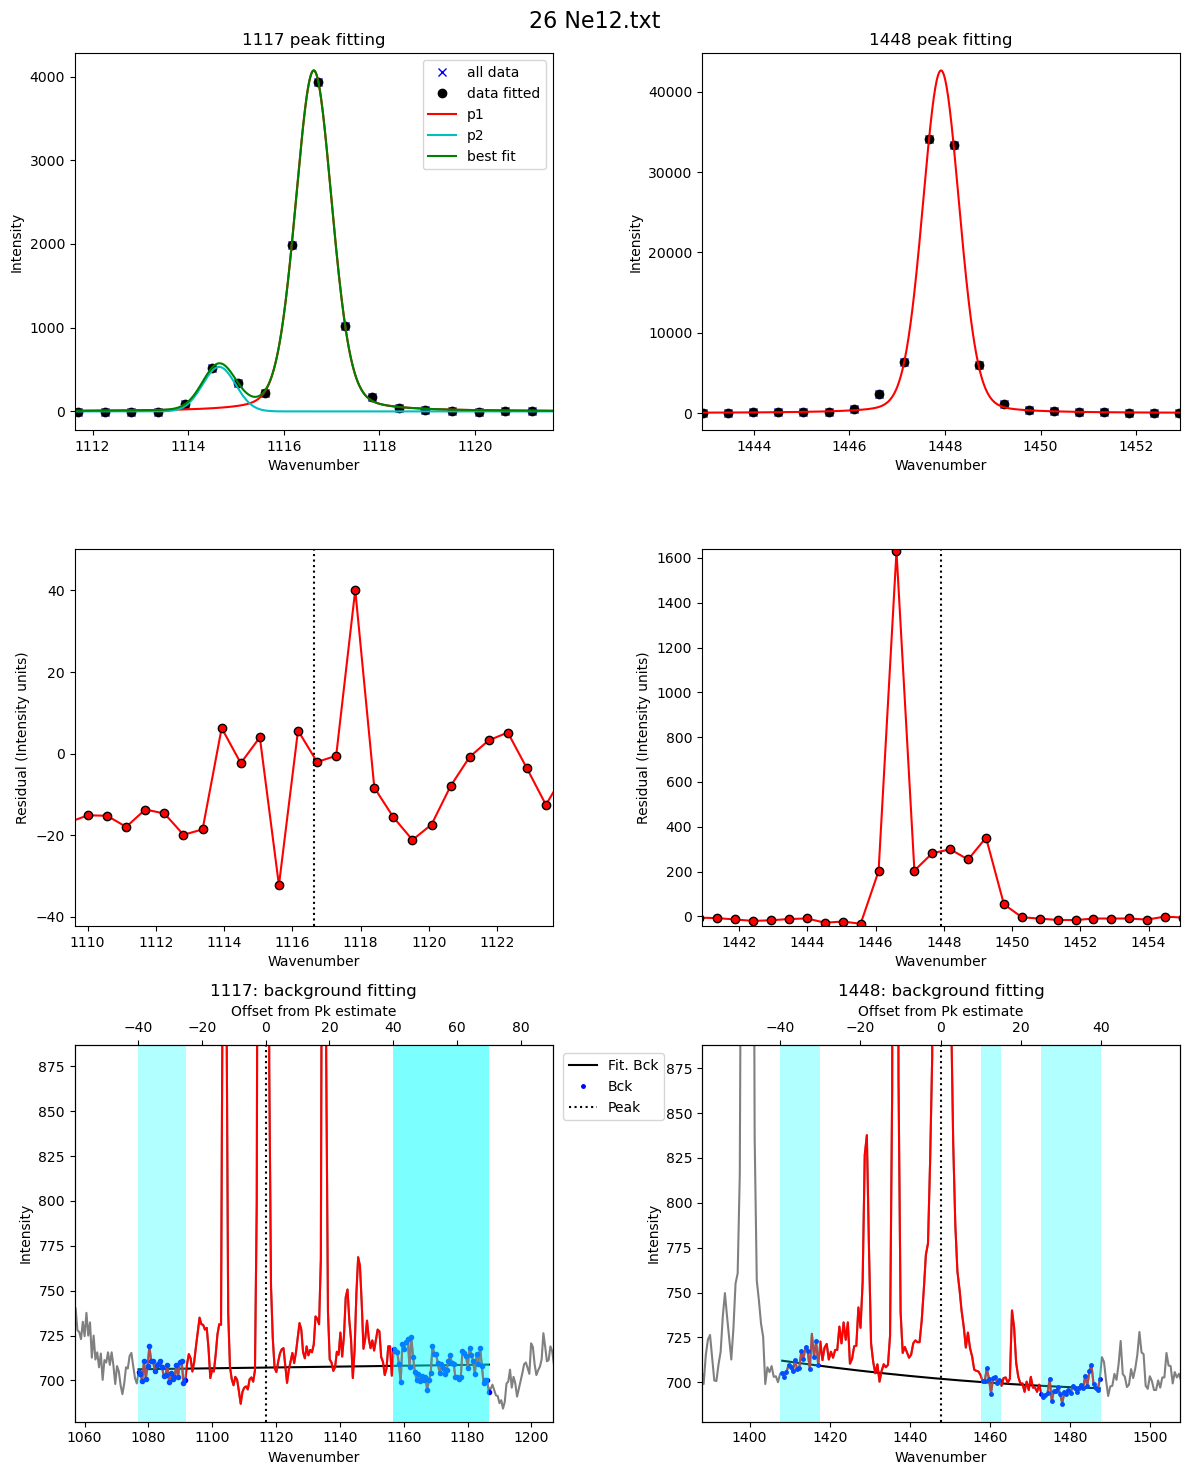

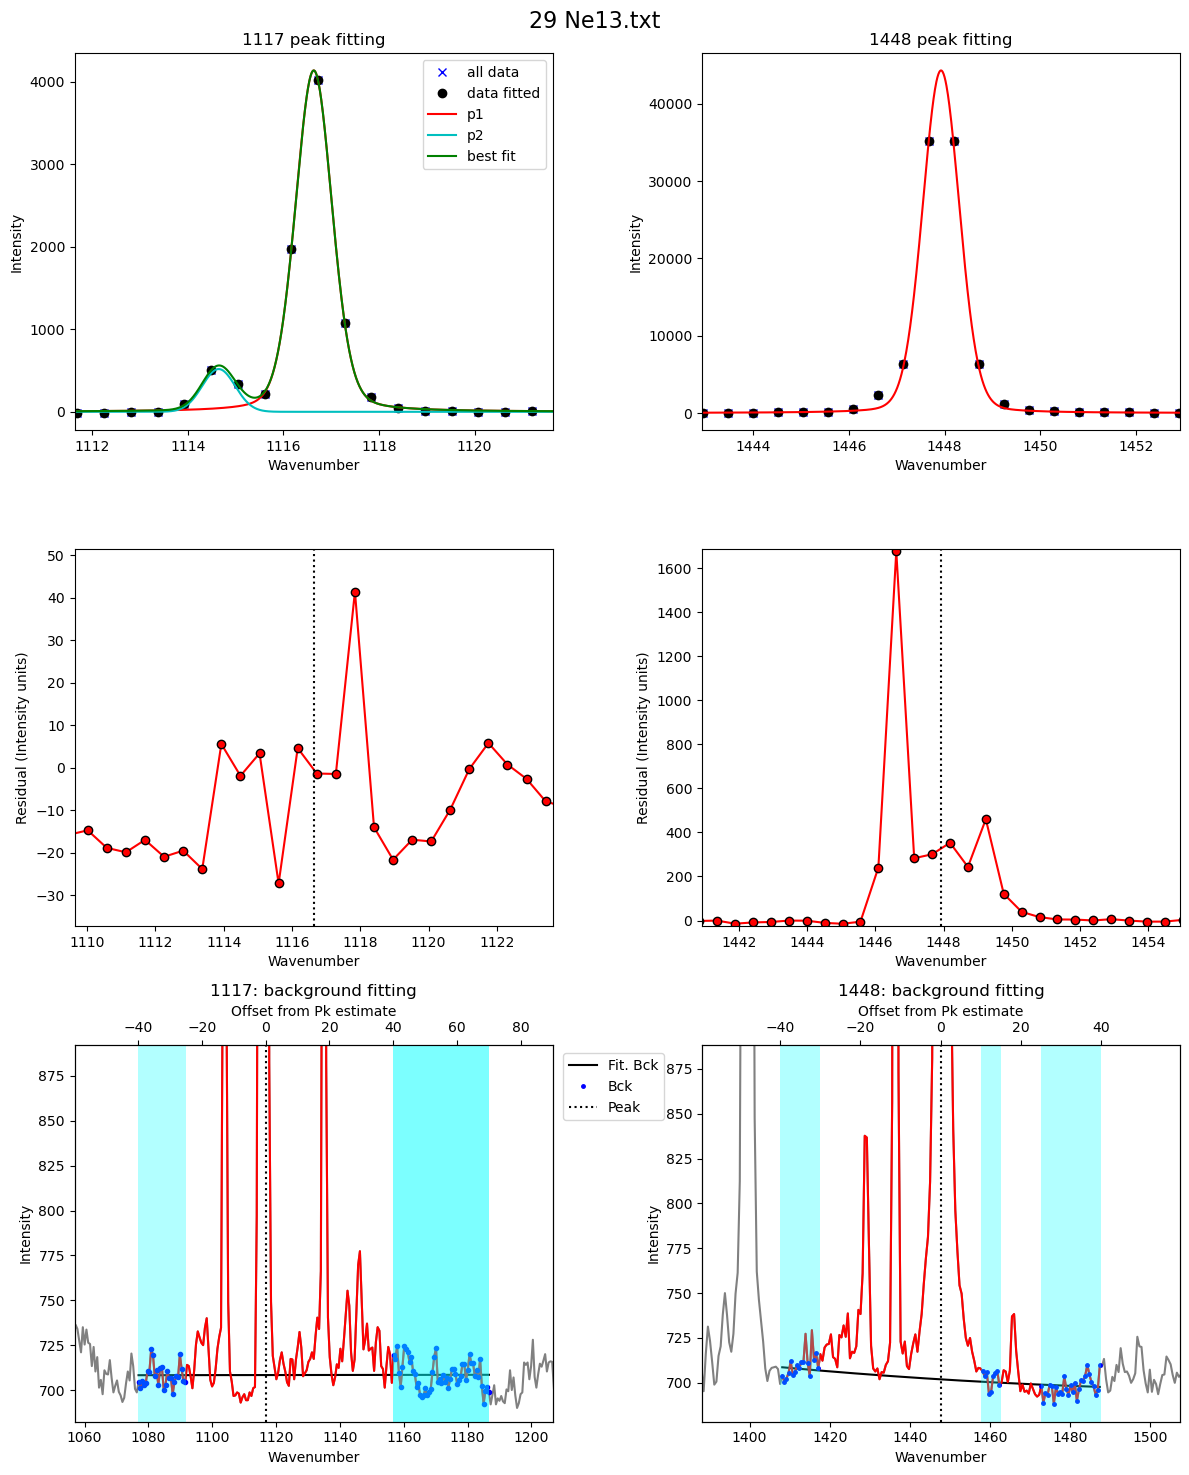

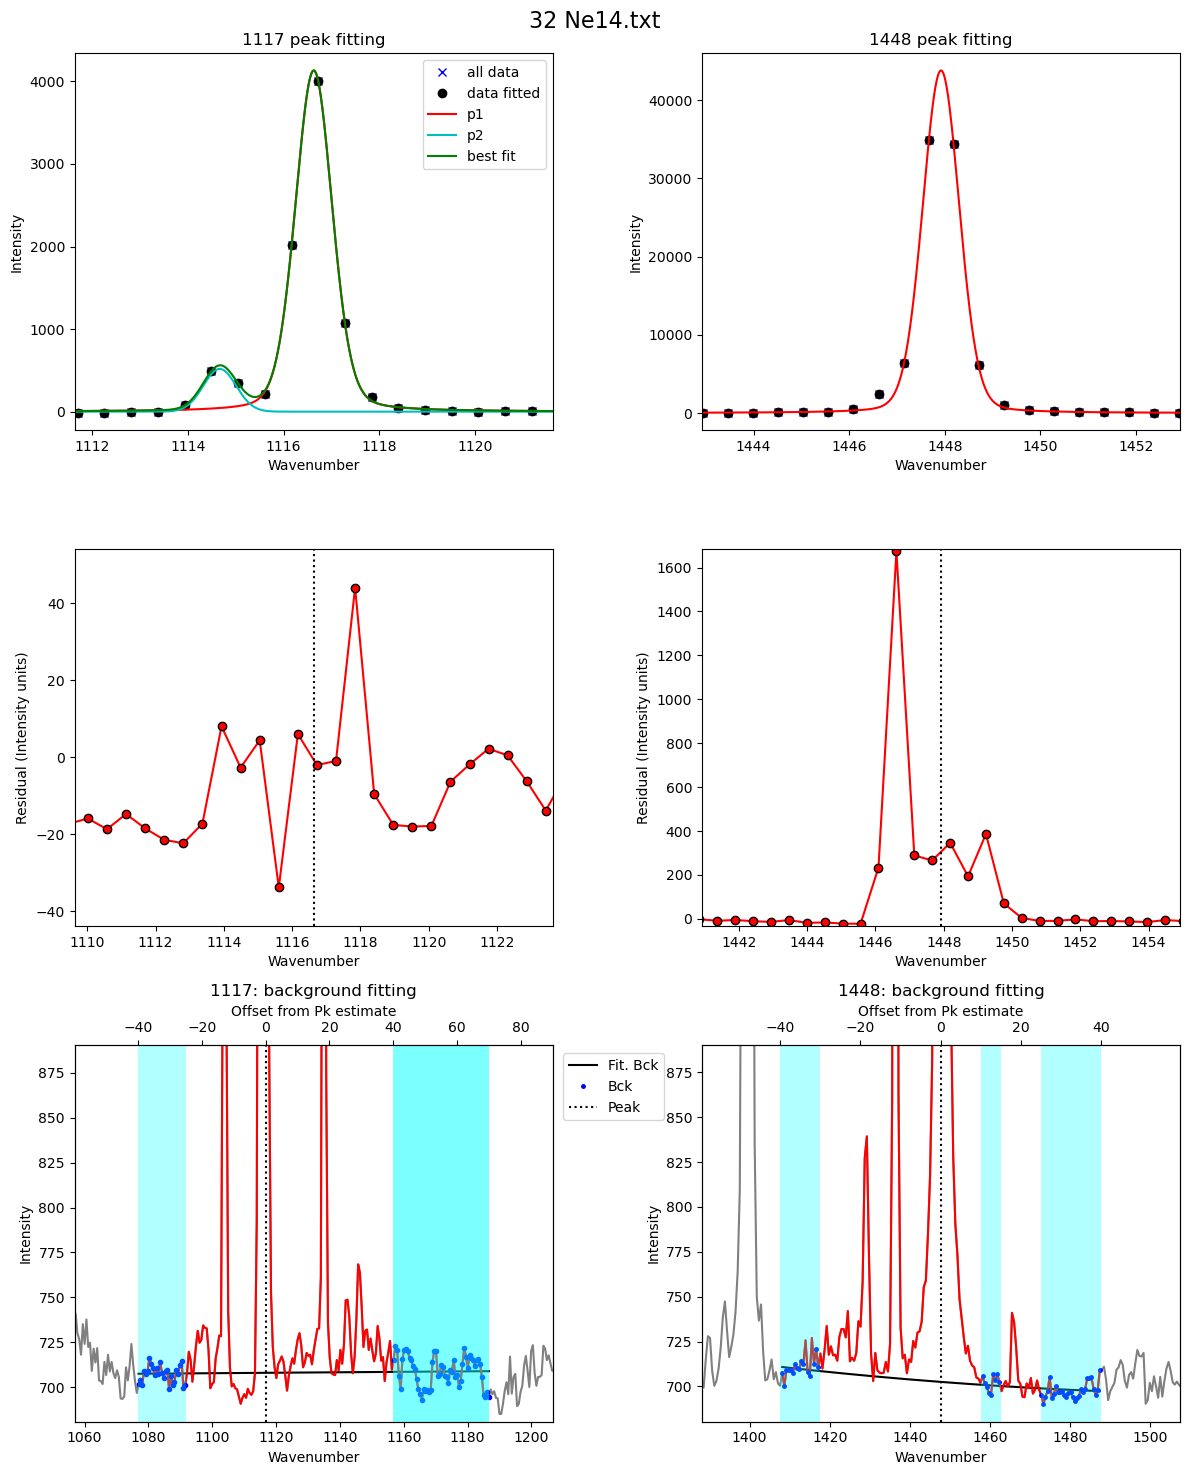

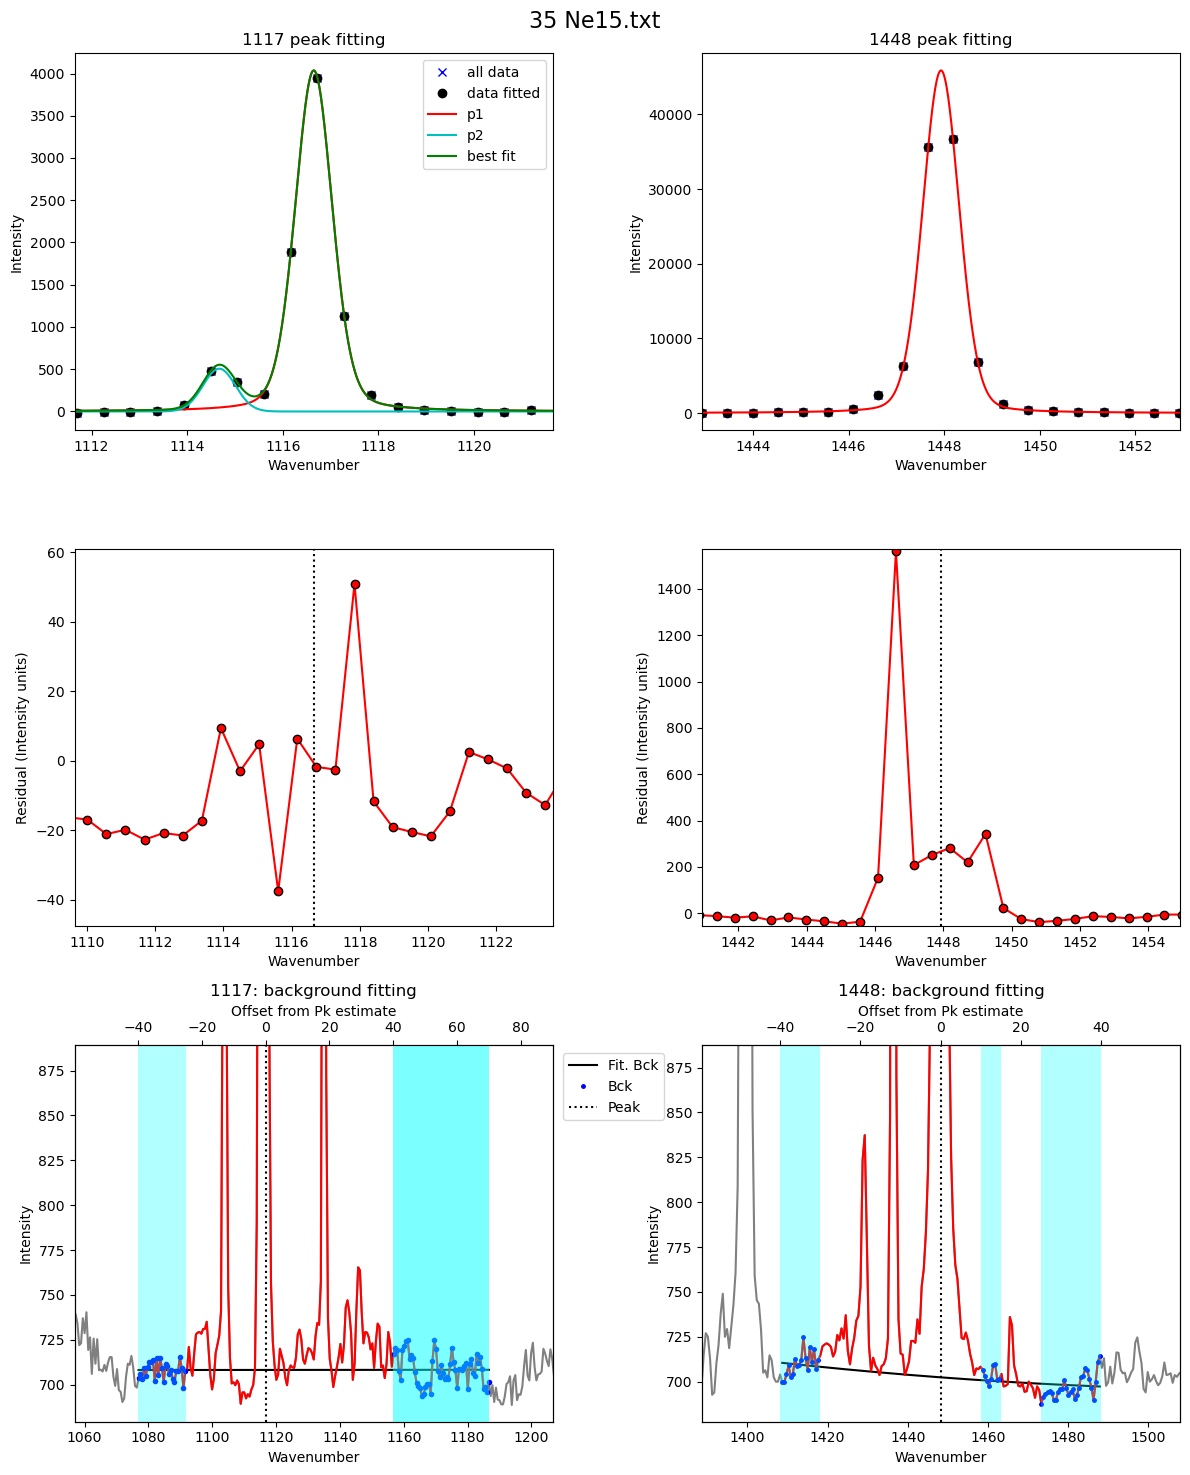

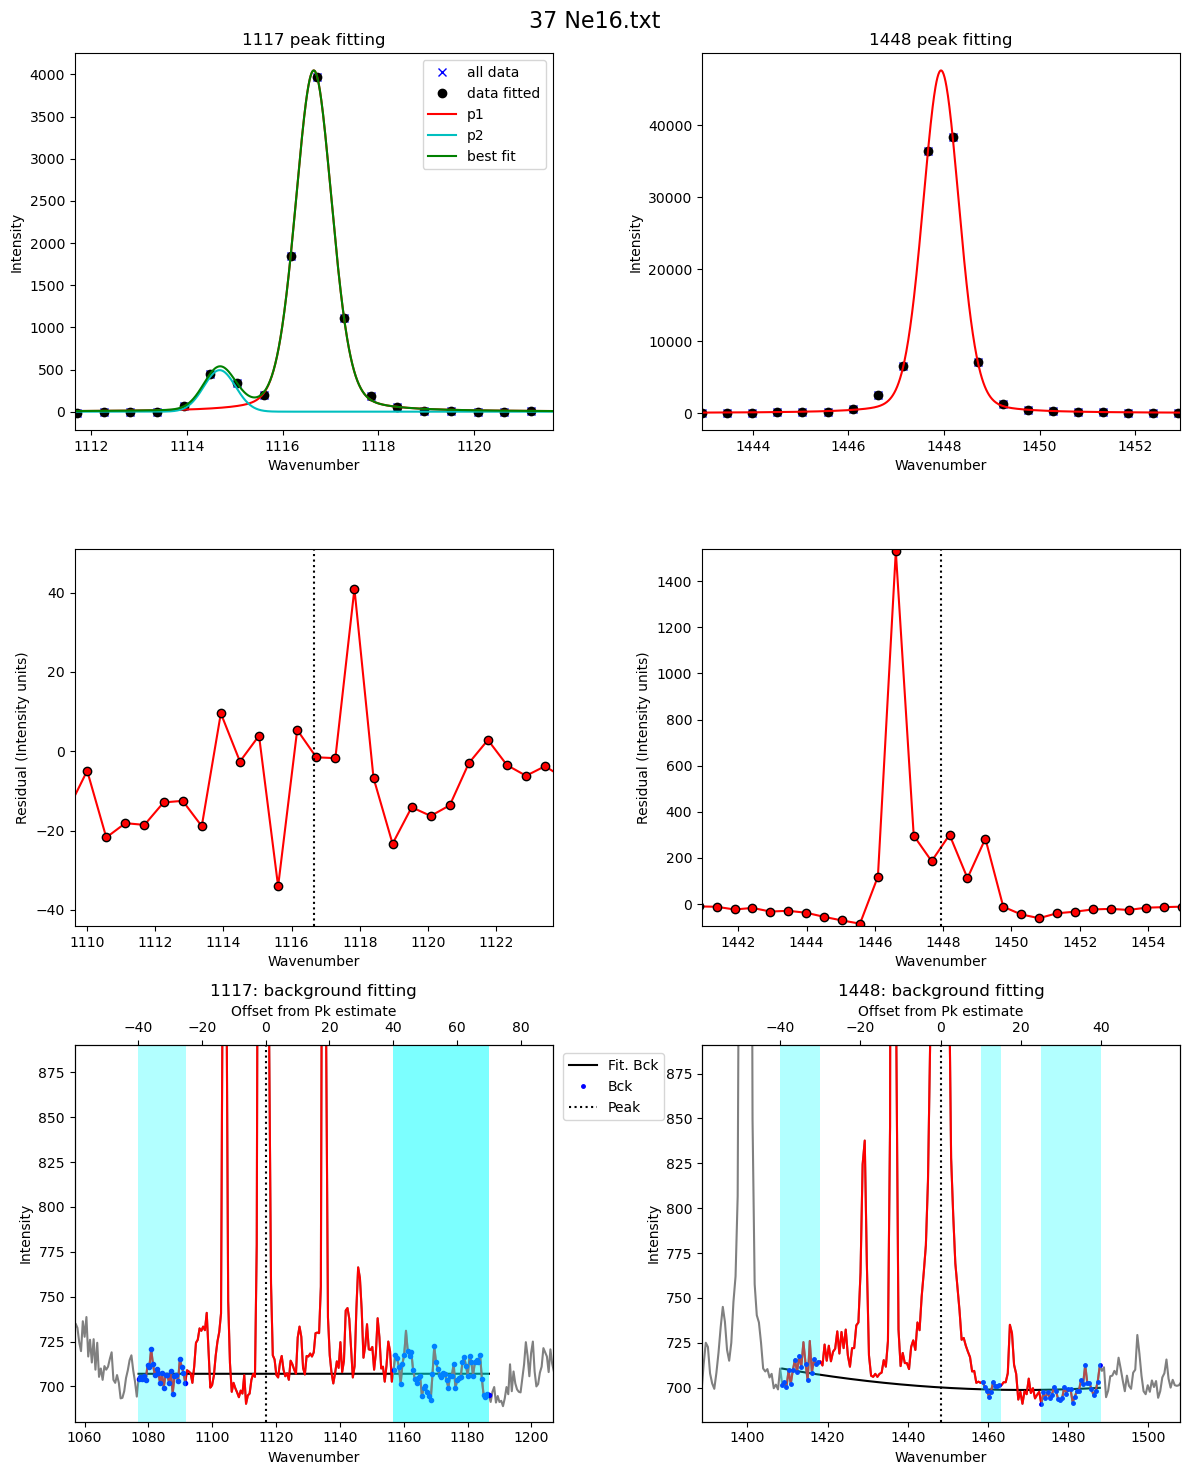

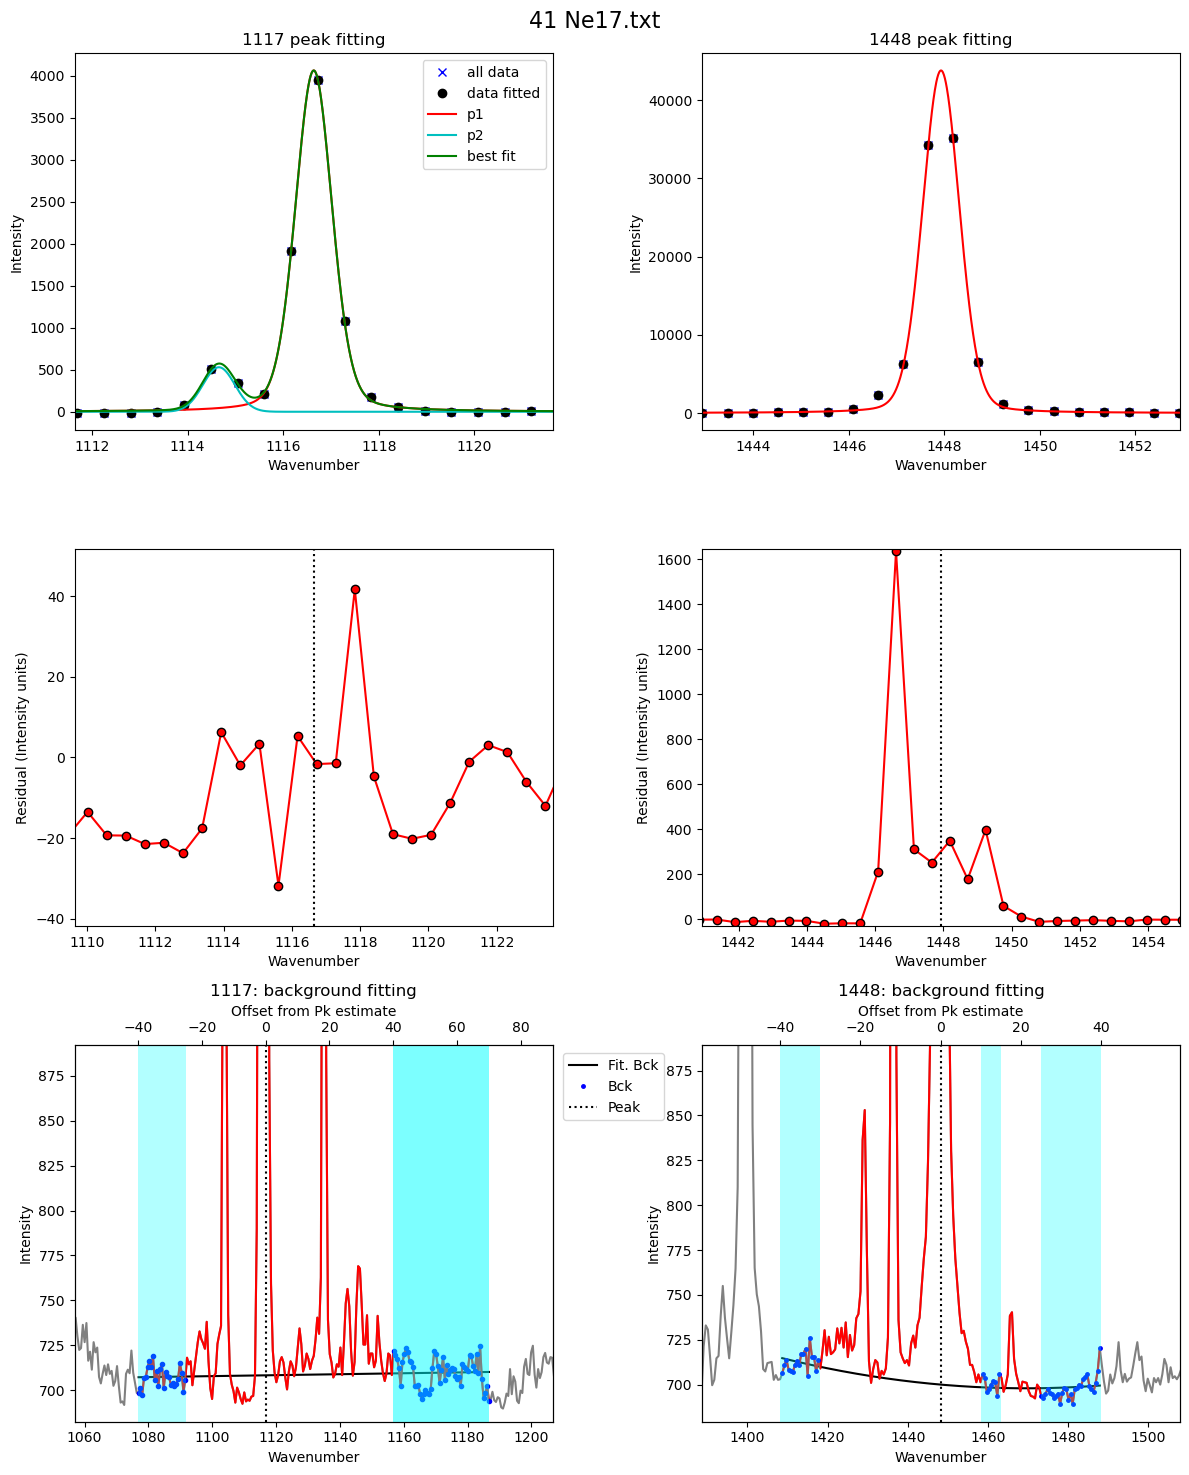

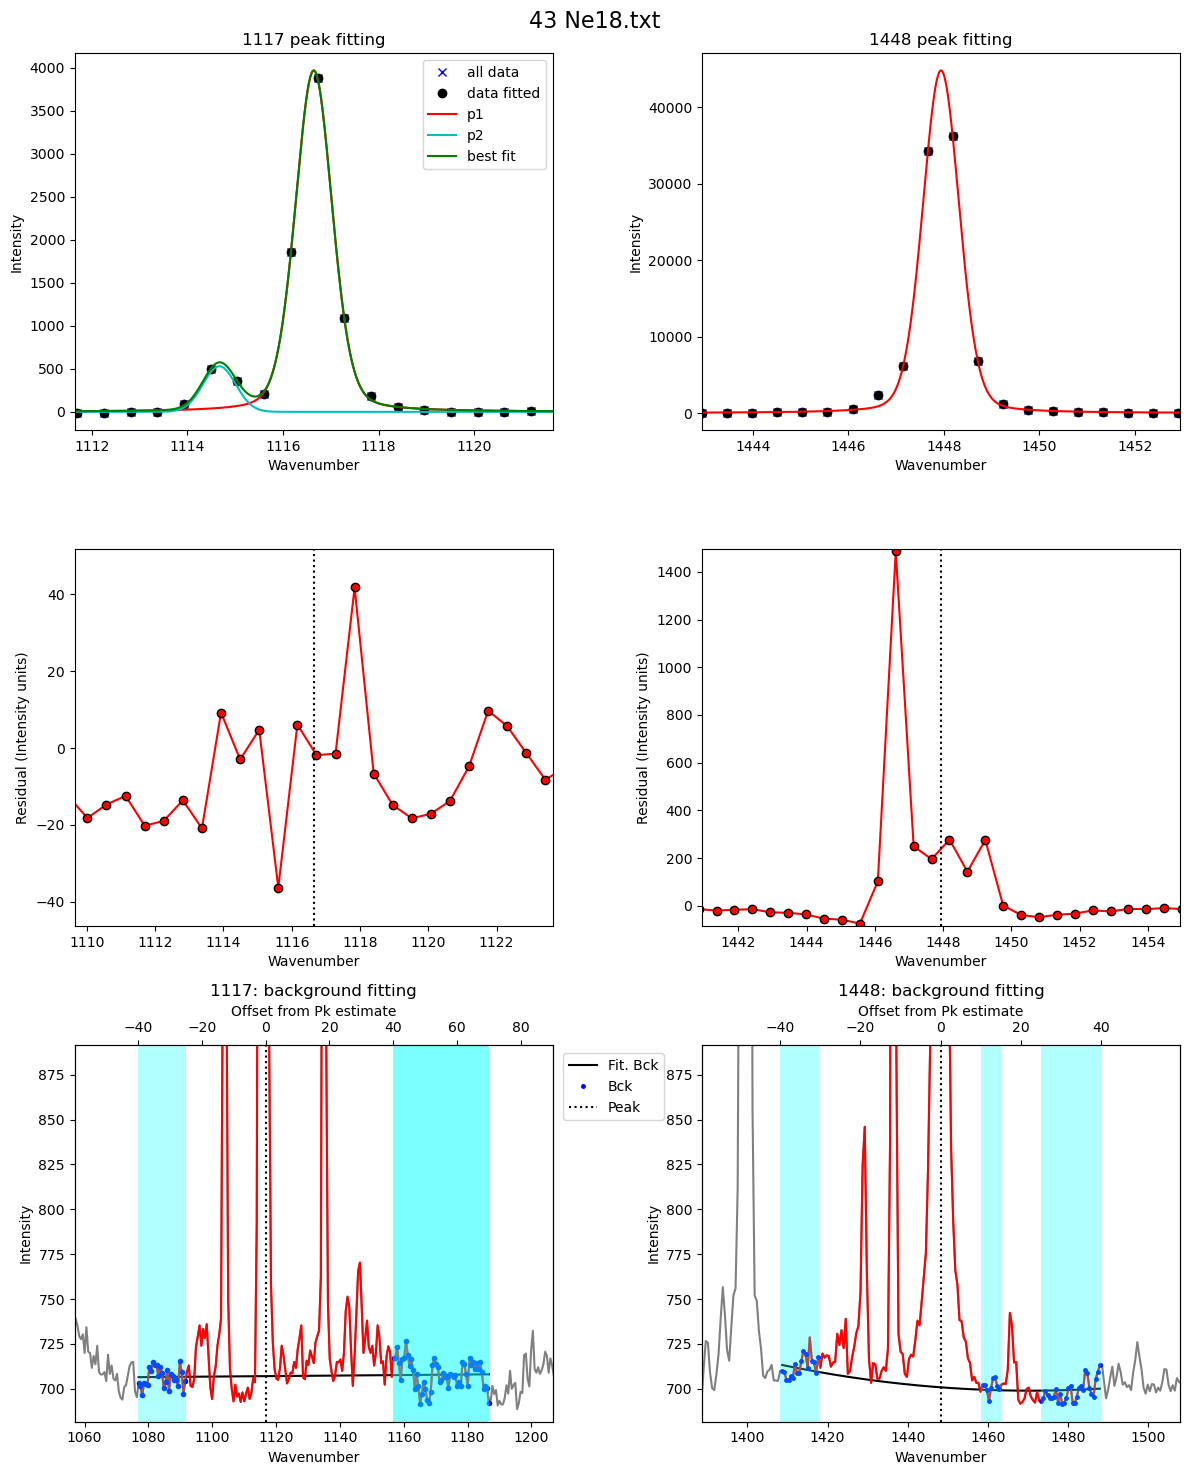

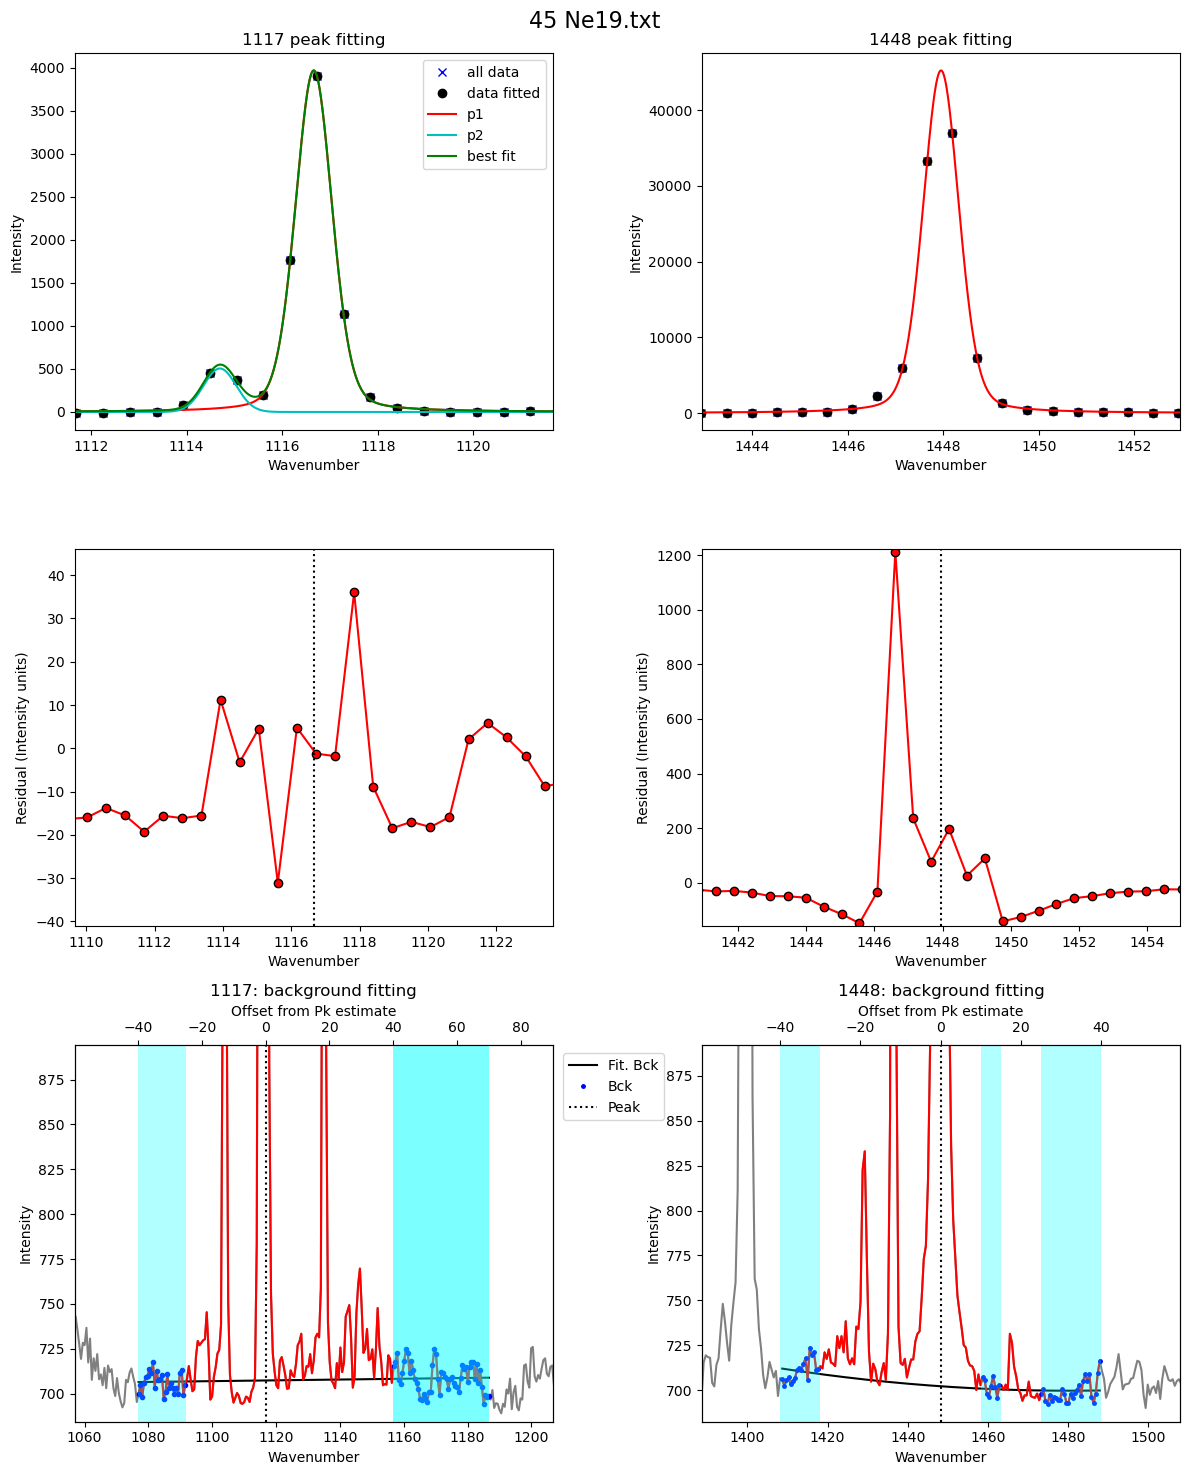

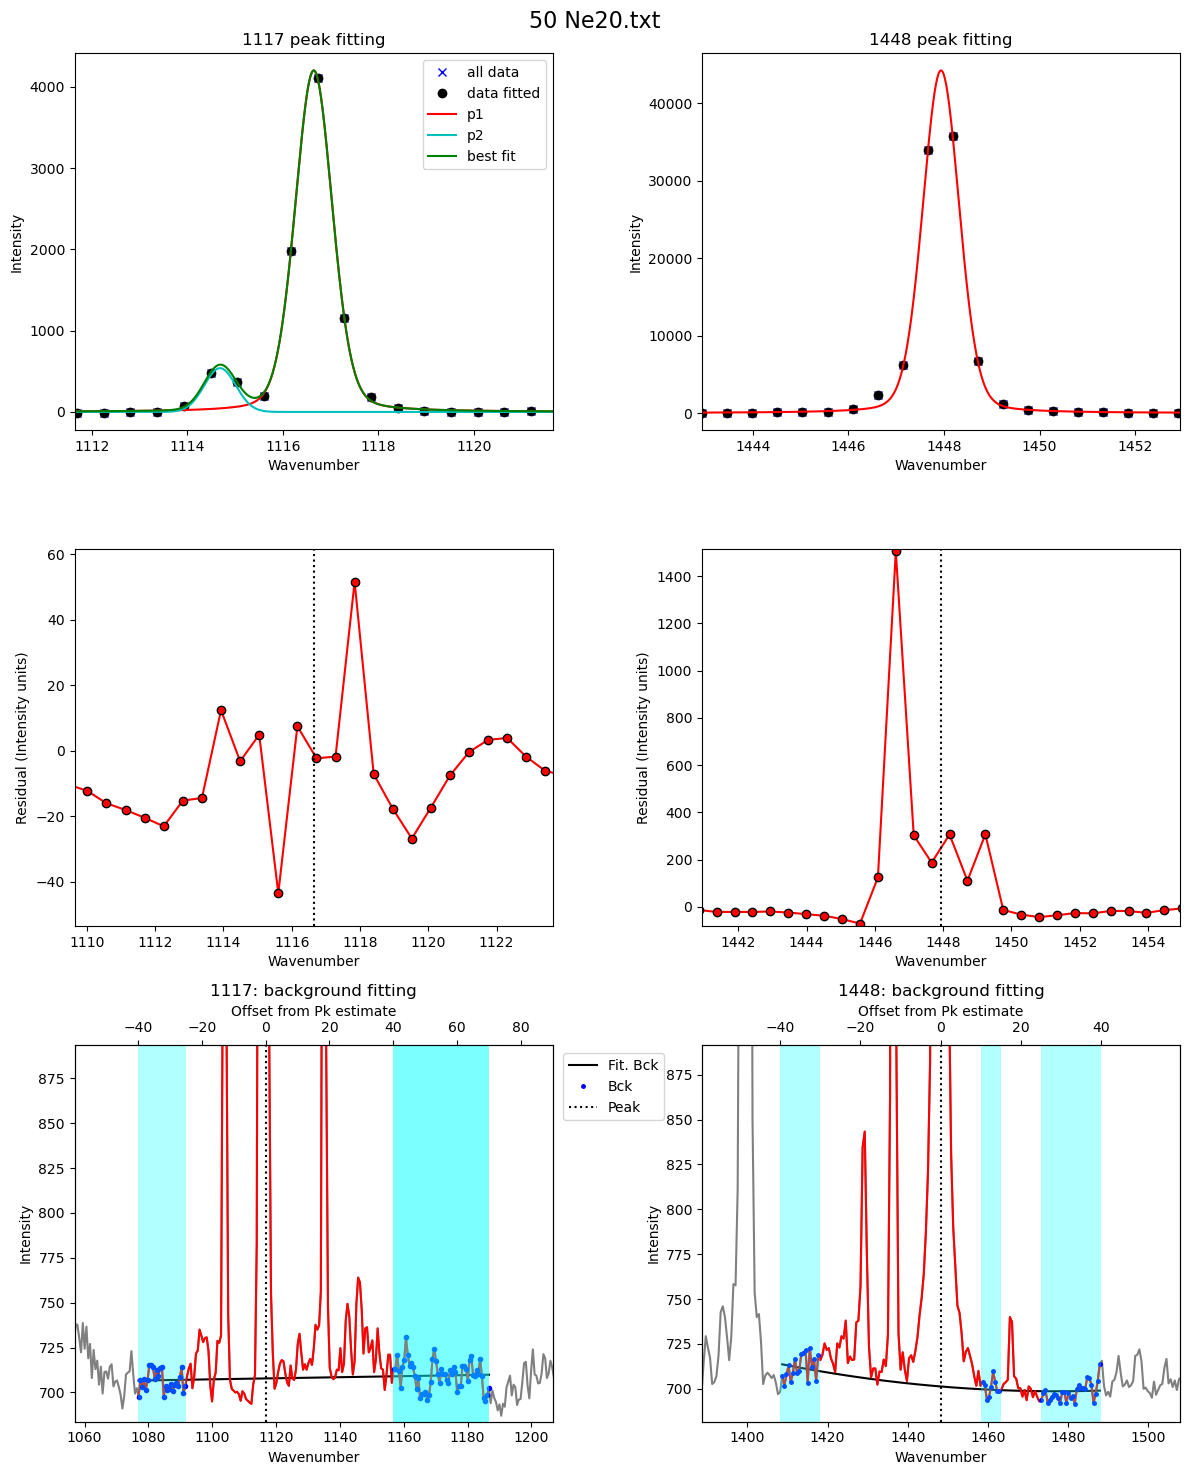

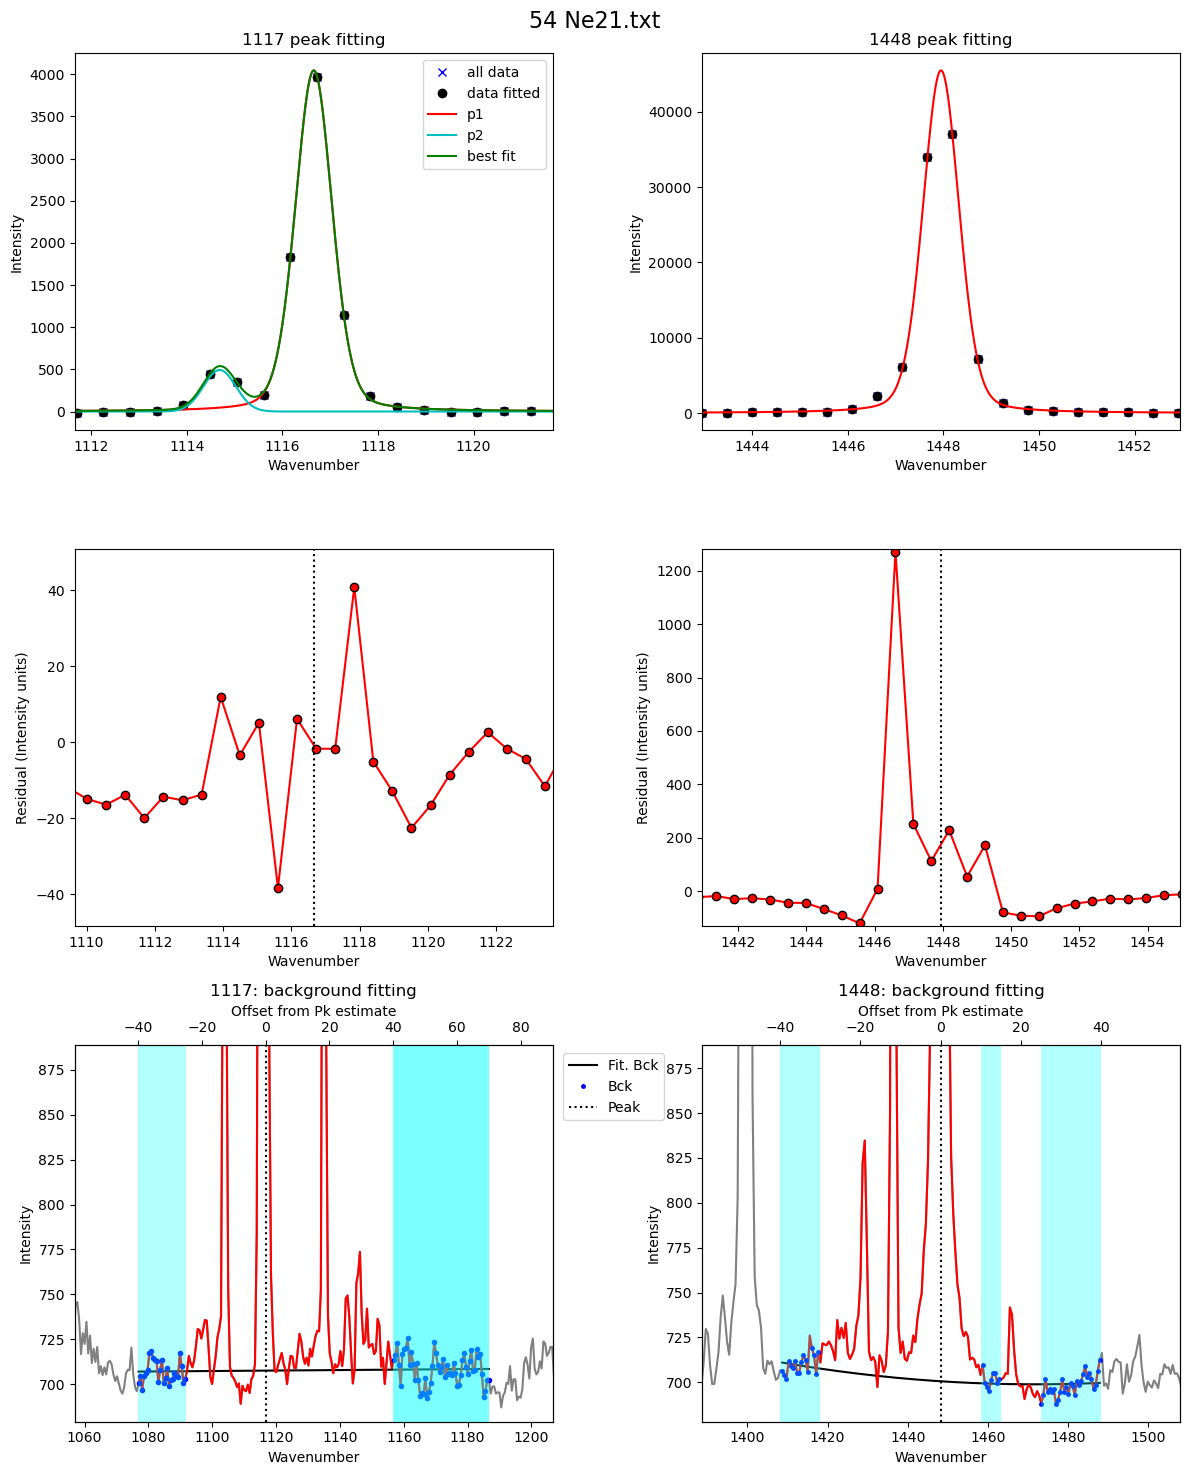

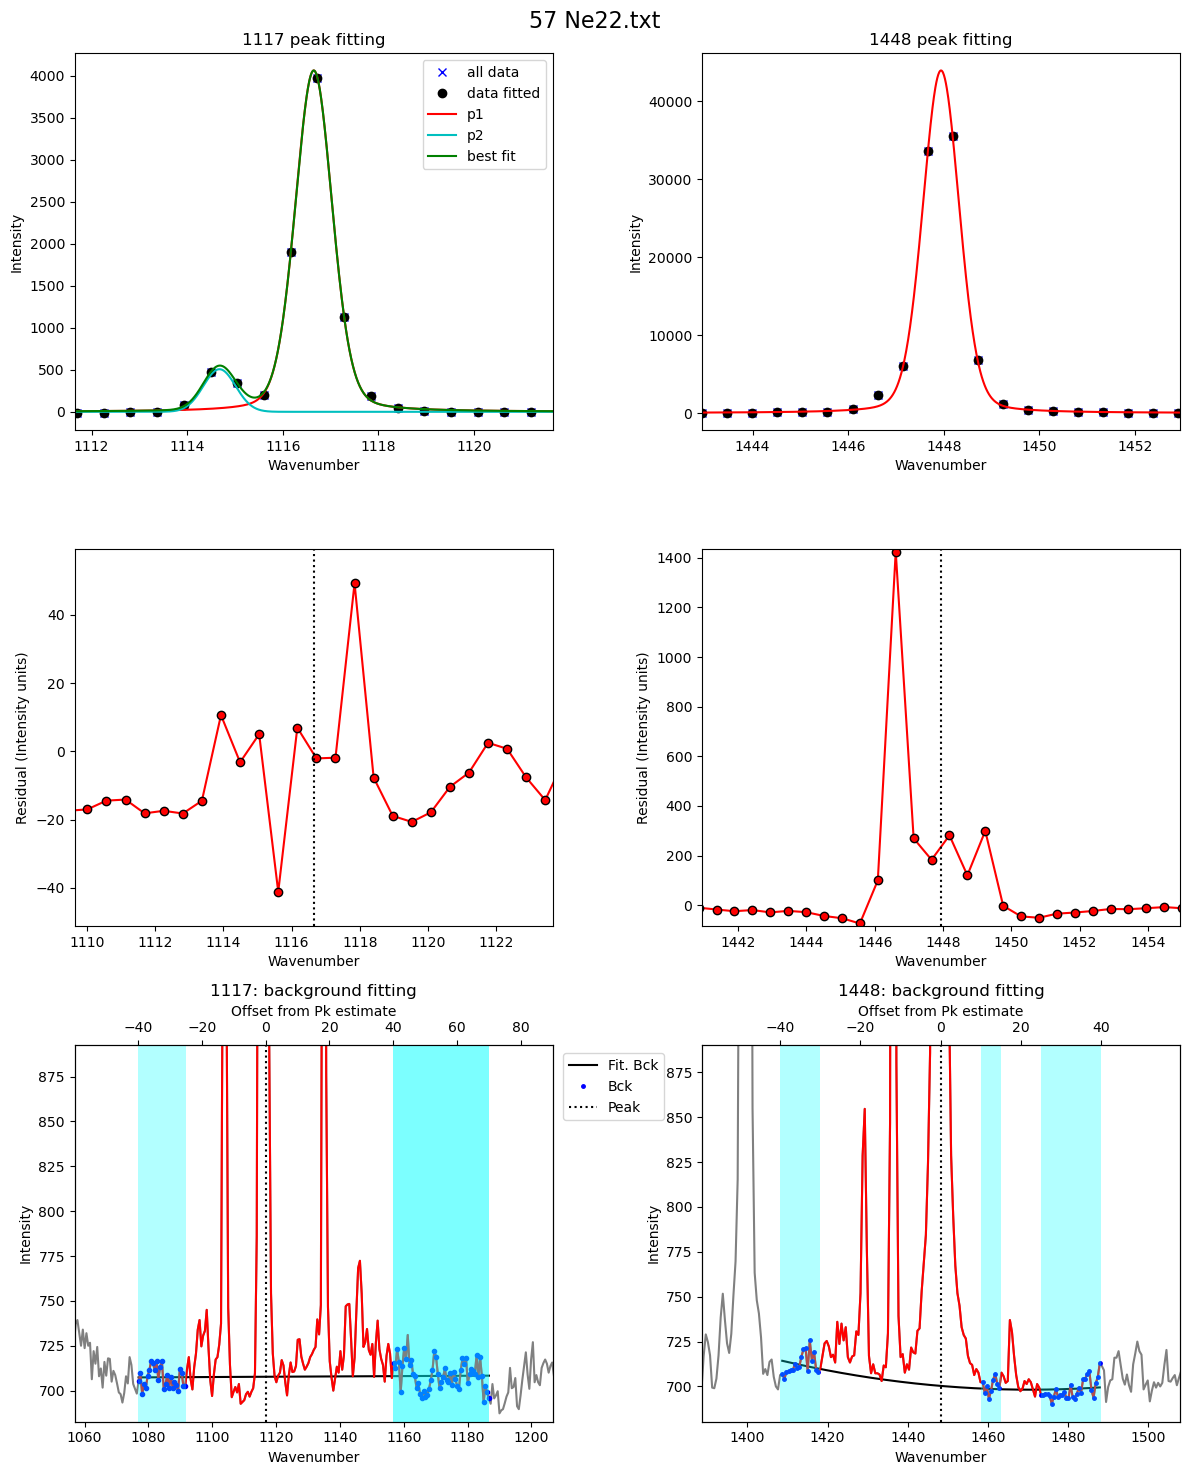

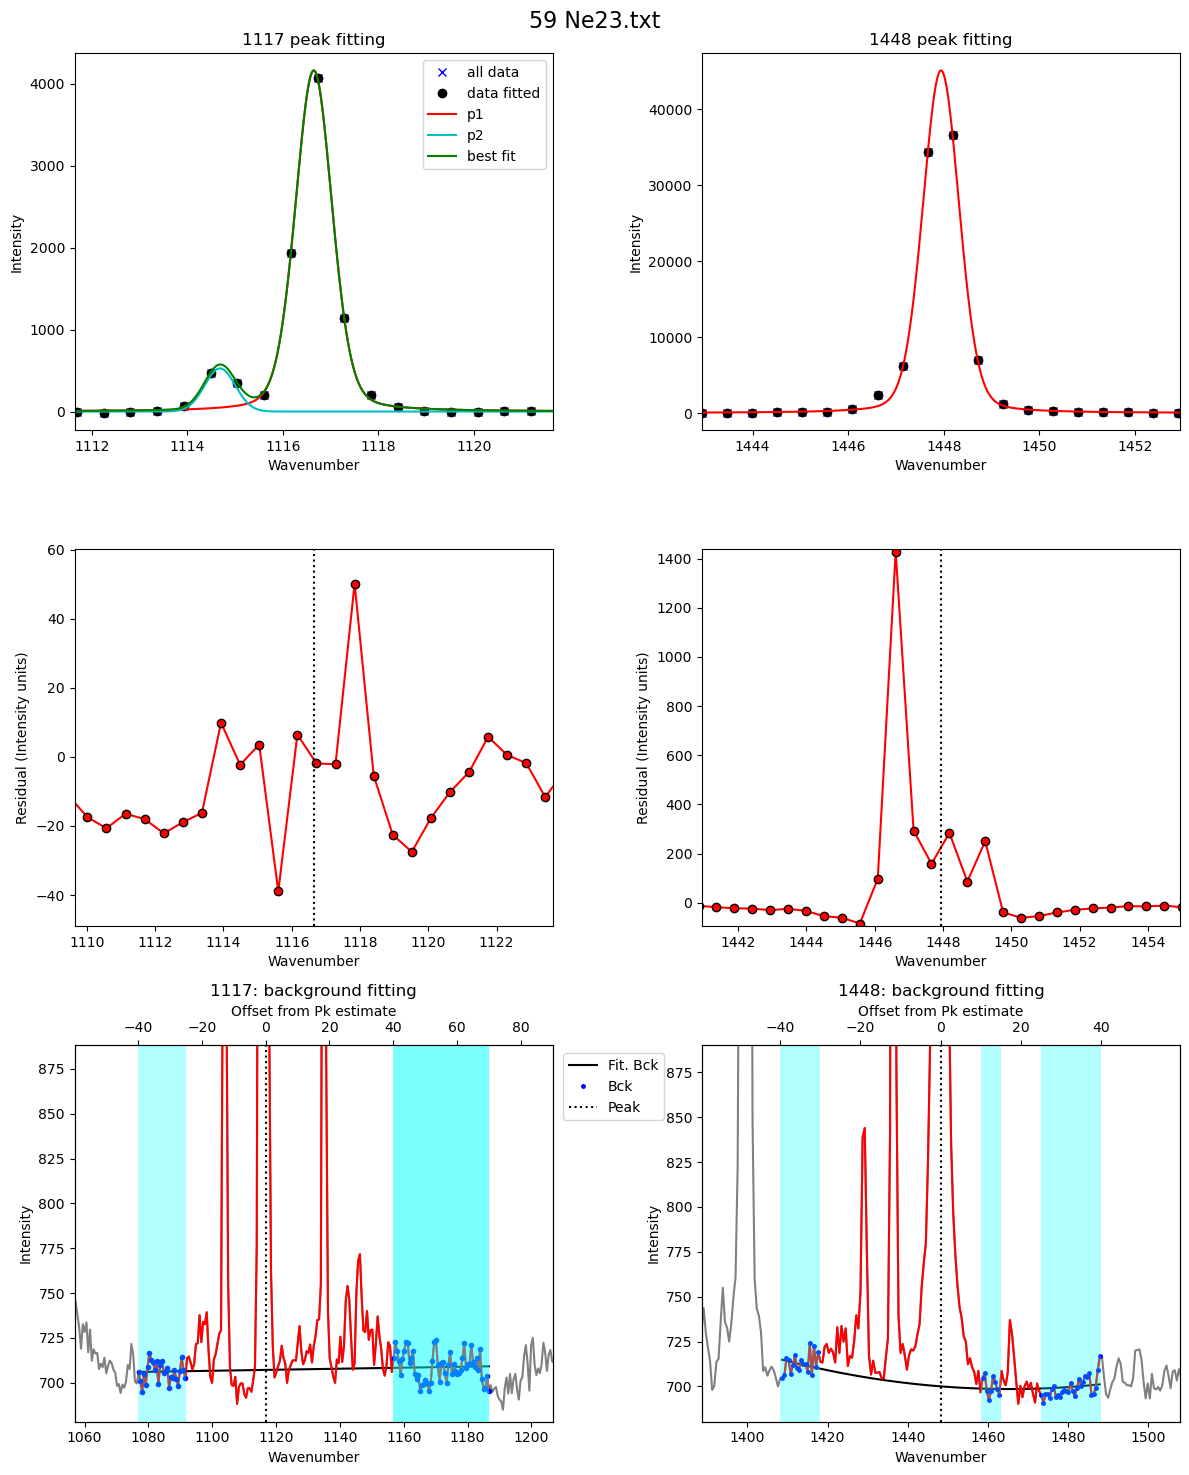

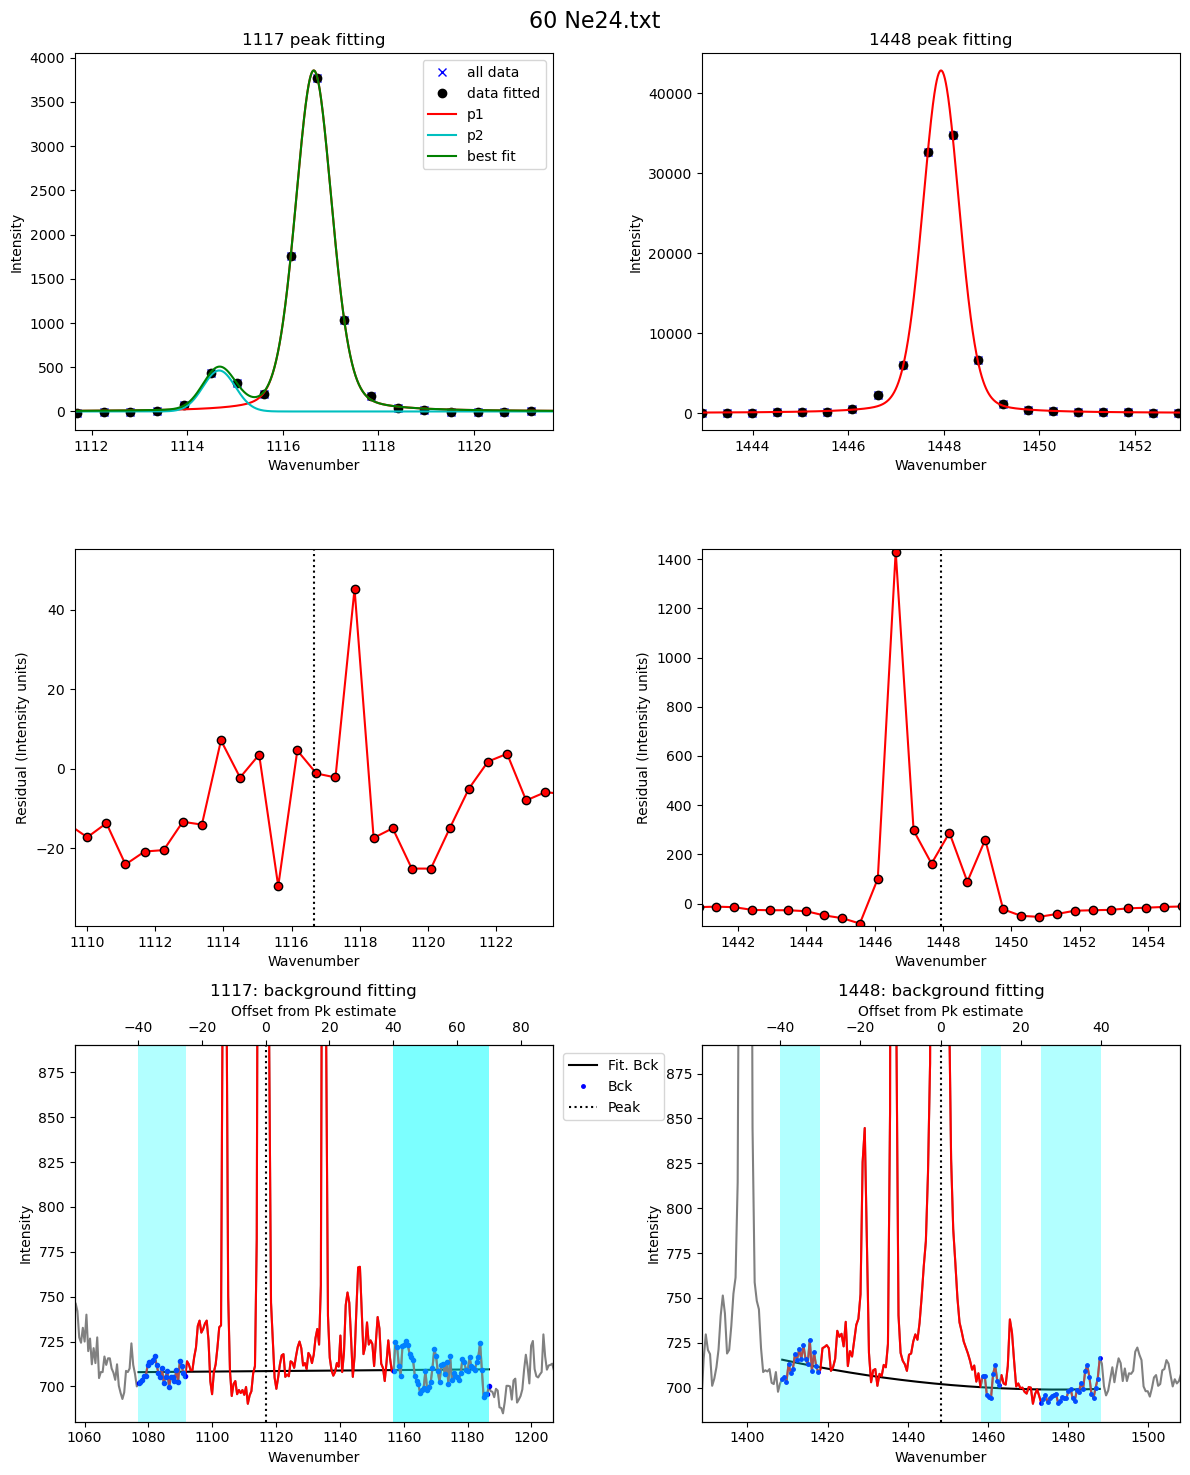

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    Ne1.txt  0.997584    0.000039  331.278023    1447.883401    1116.605378   
1    Ne2.txt  0.997592    0.000038  331.275230    1447.888903    1116.613672   
2    Ne3.txt  0.997587    0.000038  331.276848    1447.890882    1116.614035   
3    Ne4.txt  0.997588    0.000037  331.276691    1447.893019    1116.616328   
4    Ne5.txt  0.997591    0.000037  331.275830    1447.899395    1116.623566   
5    Ne6.txt  0.997584    0.000036  331.277976    1447.903648    1116.625672   
6    Ne7.txt  0.997582    0.000036  331.278640    1447.907541    1116.628902   
7    Ne8.txt  0.997553    0.000036  331.288463    1447.921390    1116.632927   
8    Ne9.txt  0.997544    0.000037  331.291364    1447.922648    1116.631284   
9   Ne10.txt  0.997563    0.000036  331.284956    1447.919178    1116.634222   
10  Ne11.txt  0.997556    0.000036  331.287178    1447.912803    1116.625625   
11  Ne12.txt  0.997544    0.000037  331.291447    1447.918506    1116.627059   
12  Ne13.txt  0.997553    0.000036  331.288244    1447.924350    1116.636106   
13  Ne14.txt  0.997549    0.000036  331.289629    1447.920755    1116.631125   
14  Ne15.txt  0.997562    0.000037  331.285440    1447.933911    1116.648471   
15  Ne16.txt  0.997556    0.000036  331.287191    1447.938088    1116.650897   
16  Ne17.txt  0.997543    0.000037  331.291531    1447.931663    1116.640132   
17  Ne18.txt  0.997534    0.000038  331.294642    1447.939938    1116.645295   
18  Ne19.txt  0.997539    0.000037  331.293096    1447.952535    1116.659439   
19  Ne20.txt  0.997540    0.000035  331.292664    1447.938121    1116.645457   
20  Ne21.txt  0.997540    0.000037  331.292608    1447.948320    1116.655712   
21  Ne22.txt  0.997537    0.000036  331.293458    1447.940573    1116.647115   
22  Ne23.txt  0.997528    0.000035  331.296482    1447.942218    1116.645736   
23  Ne24.txt  0.997536    0.000038  331.294075    1447.941446    1116.647371   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  ...  pk2_gamma  \
0    46437.287832    4087.888743    109.967799     11.271818  ...       None   
1    45873.281041    4136.274484    106.656342      9.722831  ...       None   
2    45929.019128    4051.373774    101.846785     11.309074  ...       None   
3    45366.028074    4153.108175     95.332695     11.260334  ...       None   
4    47324.474418    4285.193056     88.765906     12.049921  ...       None   
5    46802.998684    4318.870362     86.570625     13.280680  ...       None   
6    46591.787603    4372.695117     88.045311     11.968332  ...       None   
7    46207.555923    4360.286311     96.866763     12.589303  ...       None   
8    44442.525921    4408.839043     93.777962     12.579598  ...       None   
9    46714.342115    4432.393919     94.011545     10.700673  ...       None   
10   44453.982487    4462.216248     87.737072     11.821652  ...       None   
11   43651.329750    4324.598783     93.254464     11.877084  ...       None   
12   44994.576373    4390.629146     99.866727     12.731417  ...       None   
13   44640.112003    4405.567763     96.655144     12.692265  ...       None   
14   46970.860032    4364.608729     92.387552     13.847112  ...       None   
15   48909.546079    4312.397931     92.924663     11.789492  ...       None   
16   44930.442703    4326.803771     93.590381     12.707696  ...       None   
17   46277.223703    4261.379807     88.499708     12.292765  ...       None   
18   47302.540715    4241.197337     87.104816     11.849608  ...       None   
19   45646.351737    4491.164396     90.466910     12.693501  ...       None   
20   47362.160519    4334.562642     83.163596     11.784931  ...       None   
21   45456.132538    4342.401014     86.263141     12.766574  ...       None   
22   46783.749430    4460.268201     87.343412     13.075986  ...       None   
23   44421.278531    4101.153870     87.321672     12.940110  ...       None   

  

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['01 Ne1.txt', '02 Ne2.txt', '03 Ne3.txt', '04 Ne4.txt', '05 Ne5.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 24/24 [00:22<00:00,  1.06it/s]

Done


filename            date Month  Day  power (mW)  Int_time (s)  \
0  Ne1.txt  June 8, 2023\n  June  8.0      34.430          45.0   
1  Ne2.txt  June 8, 2023\n  June  8.0      34.438          45.0   
2  Ne3.txt  June 8, 2023\n  June  8.0      34.495          45.0   
3  Ne4.txt  June 8, 2023\n  June  8.0      34.506          45.0   
4  Ne5.txt  June 8, 2023\n  June  8.0      34.477          45.0   

   accumulations  Mag (X)             duration      24hr_time  \
0            3.0      5.0  ['0h', '2m', '19s']  12:01:31 PM\n   
1            3.0      5.0  ['0h', '2m', '16s']  12:05:23 PM\n   
2            3.0      5.0  ['0h', '2m', '16s']  12:09:28 PM\n   
3            3.0      5.0  ['0h', '2m', '16s']  12:12:54 PM\n   
4            3.0      5.0  ['0h', '2m', '16s']  12:23:40 PM\n   

   sec since midnight  Spectral Center  
0             43291.0         1325.004  
1             43523.0         1325.004  
2             43768.0         1325.004  
3             43974.0         1325.004  
4             44620.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24'],
      dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

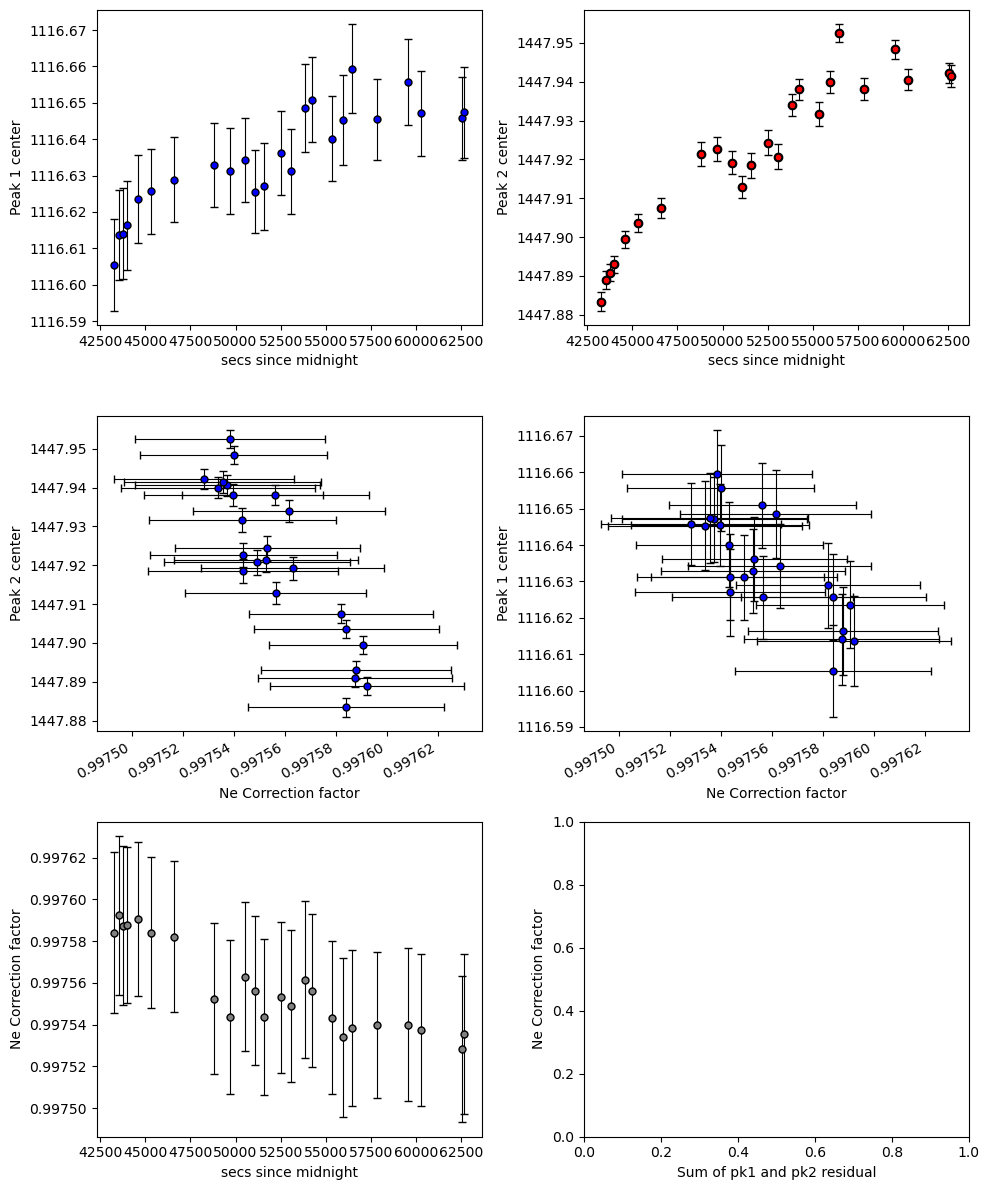

In [21]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

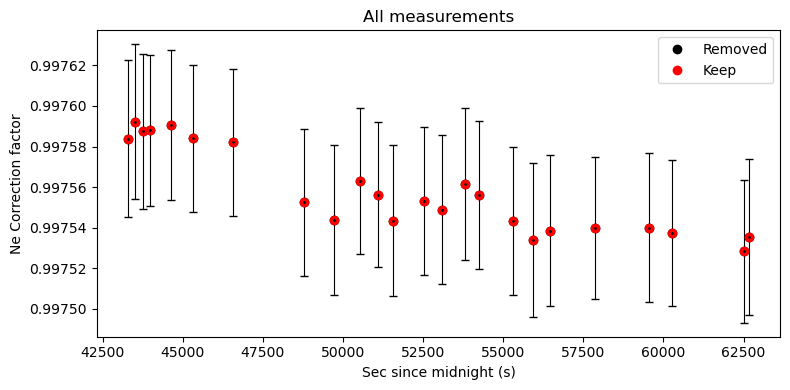

In [22]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

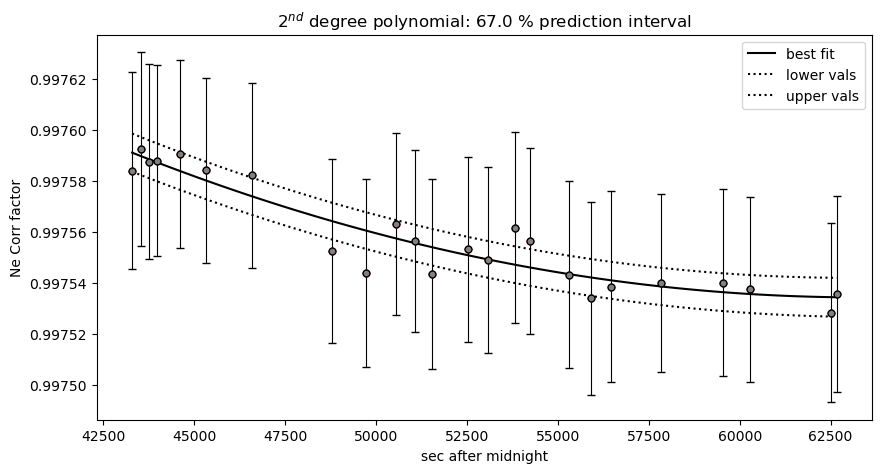

In [23]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model_1117_1147.pkl')
